# Recognition of American Sign Language Alphabets

Dataset I used contains images of hand gestures for alphabets of American sign language(ASL). So in this dataset there are total 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE and NOTHING.

**Downloading and importing required libraries**

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 41.7 MB/s eta 0:00:00


In [4]:
!pip install opendatasets

In [5]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import random
import opendatasets as op
import matplotlib.pyplot as plt
%matplotlib inline

**Setting random seed for random generator**

In [6]:
random_seed = 2023
np.random.seed(seed=random_seed)
random.seed(random_seed)

* Downloading dataset from Kaggle
    link: https://www.kaggle.com/datasets/grassknoted/asl-alphabet

In [8]:
# Dataset link
link = 'https://www.kaggle.com/datasets/grassknoted/asl-alphabet'
op.download(link)

100%|██████████| 1.03G/1.03G [00:15<00:00, 69.8MB/s]


Getting required data file paths using os library

In [9]:
root = '/content/asl-alphabet'
subRoot_path = os.listdir(root)
print(subRoot_path)

['asl_alphabet_test', 'asl_alphabet_train']


In [10]:
if subRoot_path[0] == 'asl_alphabet_test':
    testRoot_path = os.path.join(root, subRoot_path[0], subRoot_path[0])
    trainRoot_path = os.path.join(root, subRoot_path[1], subRoot_path[1])
else:
    testRoot_path = os.path.join(root, subRoot_path[1], subRoot_path[1])
    trainRoot_path = os.path.join(root, subRoot_path[0], subRoot_path[0])

testData_path = [os.path.join(testRoot_path, i) for i in os.listdir(testRoot_path)]
trainData_dir = [os.path.join(trainRoot_path, i) for i in os.listdir(trainRoot_path)]
labels = os.listdir(trainRoot_path)
print(testData_path[:10])
# print(trainData_dir)
print(labels)

['/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/Z_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/M_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/N_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/B_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/P_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/C_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/J_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/L_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/T_test.jpg', '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/E_test.jpg']
['nothing', 'T', 'M', 'I', 'H', 'O', 'P', 'N', 'U', 'D', 'R', 'Y', 'S', 'L', 'X', 'B', 'space', 'F', 'E', 'Z', 'J', 'Q', 'A', 'V', 'C', 'G', 'W', 'K', 'del']


In [ ]:
trainData_dir

['/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/K',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/V',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/T',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/S',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/U',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/I',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/D',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/F',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/X',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/H',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/B',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Q',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/C',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/space',
 '/con

## Getting data ready

Below code uses ```mediapipe``` library to get 21 points on hand to get hand position as shown below. This images is taken from mediapipe documnetation.
For more details refer to: https://github.com/google/mediapipe/blob/master/docs/solutions/hands.md



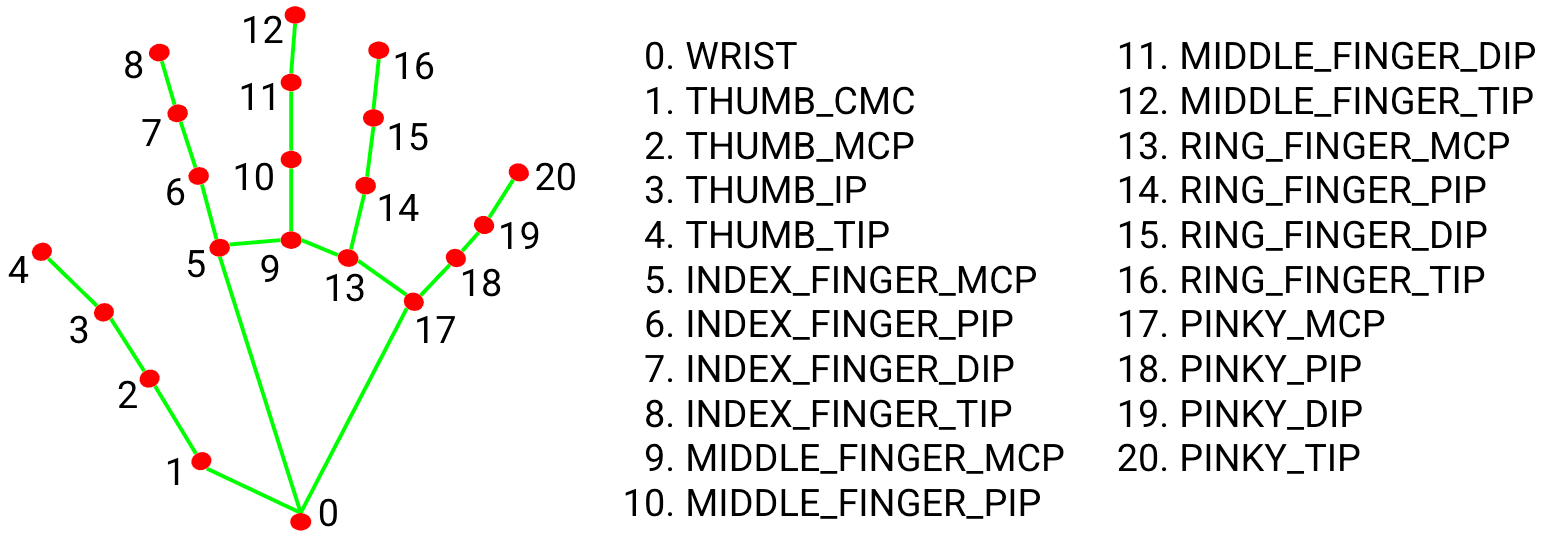

In [11]:
from re import X
import cv2 as cv
import mediapipe as mp
import time
import math


class handDetector():
    def __init__(self,mode=False,maxHands=2,modelComplexity=1,detectionCon=0.5,trackCon=0.5):
        # This are the inputs for hand detecting function of mediapipe
        self.mode = mode
        self.maxHands = maxHands
        self.modelComplexity = modelComplexity
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        # initializing the detector
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode,self.maxHands,
                                        self.modelComplexity,
                                        self.detectionCon,
                                        self.trackCon)
        # This is usful for drawing all 21 point on detected hand
        self.mpDraw = mp.solutions.drawing_utils
        # This are the points on hand for which i have found angles
        # on and used for some models. let's take 6-7-8 we get angle of index finger dip
        self.posPoints = [
            [0,1,2],[1,2,3],[2,3,4],
            [0,5,6],[5,6,7],[6,7,8],
            [0,9,10],[9,10,11],[10,11,12],
            [0,13,14],[13,14,15],[14,15,16],
            [0,17,18],[17,18,19],[18,19,20]
        ]

    # This Function find wheater a hand is detected in image or not
    def findHans(self, img, draw=False):
        # imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        # print(results.multi_hand_landmarks)
        self.results = self.hands.process(img)
        if self.results.multi_hand_landmarks:
            for handLms in self.results.multi_hand_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(img, handLms,
                                               self.mpHands.HAND_CONNECTIONS)
        return img

    # This function returns the list of 21 points coordinates for detected hand
    # [[x1, y1], [x2, y2]] if also get z-axis value but the z-axis coordinates
    # are not so accurate so it was not used
    def findPosition(self, img, handNo=0):
        lmList = []
        # imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        self.results = self.hands.process(img)
        if self.results.multi_hand_landmarks:
            myHand = self.results.multi_hand_landmarks[handNo]
            for lm in myHand.landmark:
                # h, w, c = img.shape
                lmList.append([lm.x,lm.y])
        return lmList

    # Getting angles between the points using cos(teta) = (x_bar.y_bar)/(magnitude_x*magnitude_y)
    def getAngelMy(self, points: list[list[int]], lmList: list[list[int]]) -> list[int]:
        allRequiredAngels = []
        for p1, p2, p3 in points:
            x1, y1 = lmList[p1]
            x2, y2 = lmList[p2]
            x3, y3 = lmList[p3]
            allRequiredAngels.append(math.degrees(math.acos(((x2- x1)*(x3-x2) + (y2-y1)*(y3-y2))/(math.dist(lmList[p2], lmList[p1])*math.dist(lmList[p3], lmList[p2])))))
        return allRequiredAngels

    # Getting angles between points using tan(teta) = (y2 - y1)/(x2 - x1)
    def getAngle(self, points: list[list[int]], lmList: list[list[int]]) -> list[int]:
        requiredAngelsU = []
        for p1, p2, p3 in points:
            x1, y1 = lmList[p1]
            x2, y2 = lmList[p2]
            x3, y3 = lmList[p3]
            requiredAngelsU.append(math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2)))
        return requiredAngelsU

    def forAngle(self, x1, y1, x2, y2, x3, y3):
        return math.degrees(math.acos(((x2- x1)*(x3-x2) + (y2-y1)*(y3-y2))/(math.dist([x2,y2], [x1,y1])*math.dist([x3,y3], [x2,y2]))))

    def angleu(self, x1, y1, x2, y2, x3, y3):
        return math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))

## Getting Femiliar with data

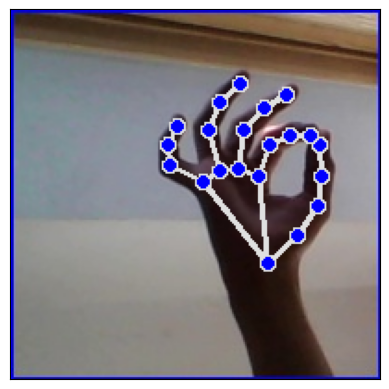

(200, 200, 3)


In [20]:
# initializing detector using above class
detector = handDetector()

# Getting random image file from dataset
getsture_file = random.choice(trainData_dir)
lable = getsture_file.split('/')[-1]
img_file = os.path.join(getsture_file, random.choice(os.listdir(getsture_file)))

# reading file to get (200, 200, 3) shaped array and detecting 21 points on hand
# Some images may not get detected
img = plt.imread(img_file)
img = detector.findHans(img, draw=True)

# Ouput the image using matplotlib
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()
print(img.shape)

## Buliding first model solely based on detected hand position

### Getting data ready for model

In [ ]:
from collections import defaultdict

data_dis = defaultdict(list)
total_data = 0
detector = handDetector()

for i, p in enumerate(trainData_dir):
    for fil in os.listdir(p):
        total_data += 1
        temp_file = os.path.join(p, fil)
        img = plt.imread(temp_file)
        coordinates = detector.findPosition(img)
        if len(coordinates) != 0 and labels[i] !='nothing':
            data_dis['label'].append(labels[i])
            data_dis['file_path'].append(temp_file)
            for j in range(len(coordinates)):
                data_dis[f'x_hand_{j}'].append(coordinates[j][0])
                data_dis[f'y_hand_{j}'].append(coordinates[j][1])
        elif labels[i]=='nothing':
            for i in range(21):
                data_dis[f'x_hand_{j}'].append(0)
                data_dis[f'y_hand_{j}'].append(0)

print(len(data_dis['label']), len(data_dis['x_hand_0']), total_data)


66010 66010 87000


From 87,000 images only in 66010 images hand was detected. Images with label nothing has no hand in it so thoes 3000 images can be taken out.

In [ ]:
print(len(data_dis['label']), len(data_dis['x_hand_0']), total_data)

66010 66010 87000


In [ ]:
for i, p in enumerate(trainData_dir):
    print(labels[i], len(os.listdir(p)))

del 3000
L 3000
O 3000
V 3000
Q 3000
G 3000
P 3000
Z 3000
I 3000
B 3000
S 3000
C 3000
F 3000
M 3000
W 3000
J 3000
H 3000
U 3000
X 3000
A 3000
N 3000
K 3000
E 3000
R 3000
nothing 3000
T 3000
D 3000
space 3000
Y 3000


Saving processed data in ```.parquet``` file and reading in from file.

In [ ]:
import pandas as pd
# df = pd.DataFrame(data_dis)
# df.to_csv('cleanedASL.csv')
# df.to_parquet('cleaned_ASL.parquet')
df = pd.read_parquet('/content/drive/MyDrive/data/asl_cleaned_data/cleaned_ASL.parquet')

In [ ]:
df2 = df.drop(columns='file_path')
df2.head()

label  x_hand_0  y_hand_0  x_hand_1  y_hand_1  x_hand_2  y_hand_2  x_hand_3  \
0   del  0.640012  0.549258  0.603969  0.613443  0.539320  0.666677  0.484856   
1   del  0.703644  0.214589  0.659422  0.263398  0.619649  0.294278  0.587120   
2   del  0.812010  0.453296  0.758869  0.396527  0.642238  0.356300  0.533390   
3   del  0.584252  0.665317  0.553047  0.644940  0.469424  0.630440  0.393331   
4   del  0.743570  0.308794  0.703851  0.249148  0.627094  0.206340  0.545086   

   y_hand_3  x_hand_4  ...  x_hand_16  y_hand_16  x_hand_17  y_hand_17  \
0  0.713343  0.446855  ...   0.549798   0.589359   0.476179   0.509092   
1  0.336895  0.551518  ...   0.751583   0.180263   0.807003   0.166073   
2  0.369457  0.441643  ...   0.423510   0.633702   0.540103   0.439028   
3  0.643162  0.330258  ...   0.315942   0.835835   0.385209   0.678265   
4  0.207994  0.480319  ...   0.445949   0.420815   0.538324   0.290418   

   x_hand_18  y_hand_18  x_hand_19  y_hand_19  x_hand_20  y_hand_20  
0   0.495156   0.569426   0.537279   0.578356   0.552594   0.567106  
1   0.831242   0.183669   0.827715   0.193476   0.815729   0.193224  
2   0.471854   0.498762   0.453077   0.546022   0.433401   0.588540  
3   0.336830   0.730859   0.329206   0.779250   0.324796   0.819947  
4   0.490410   0.336814   0.470234   0.381444   0.450705   0.422993  

[5 rows x 43 columns]

Dropping images with "nothing" labeled.

In [ ]:
df2 = df2[df2['label']!='nothing']

By using label encoding I have converted labels into numbers.

In [ ]:
word_labels = {'del':0,'L':1,'O':2,'V':3,'Q':4,'G':5,'P':6,'Z':7,'I':8,'B':9,
               'S':10,'C':11,'F':12,'M':13,'W':14,'J':15,'H':16,'U':17,'X':18,
               'A':19,'N':20,'K':21,'E':22,'R':23,'nothing':24,'T':25,'D':26,
               'space':27,'Y':28}
df2['resuls'] = df['label'].apply(lambda x:word_labels[x])
df2.head()

label  x_hand_0  y_hand_0  x_hand_1  y_hand_1  x_hand_2  y_hand_2  x_hand_3  \
0   del  0.640012  0.549258  0.603969  0.613443  0.539320  0.666677  0.484856   
1   del  0.703644  0.214589  0.659422  0.263398  0.619649  0.294278  0.587120   
2   del  0.812010  0.453296  0.758869  0.396527  0.642238  0.356300  0.533390   
3   del  0.584252  0.665317  0.553047  0.644940  0.469424  0.630440  0.393331   
4   del  0.743570  0.308794  0.703851  0.249148  0.627094  0.206340  0.545086   

   y_hand_3  x_hand_4  ...  y_hand_16  x_hand_17  y_hand_17  x_hand_18  \
0  0.713343  0.446855  ...   0.589359   0.476179   0.509092   0.495156   
1  0.336895  0.551518  ...   0.180263   0.807003   0.166073   0.831242   
2  0.369457  0.441643  ...   0.633702   0.540103   0.439028   0.471854   
3  0.643162  0.330258  ...   0.835835   0.385209   0.678265   0.336830   
4  0.207994  0.480319  ...   0.420815   0.538324   0.290418   0.490410   

   y_hand_18  x_hand_19  y_hand_19  x_hand_20  y_hand_20  resuls  
0   0.569426   0.537279   0.578356   0.552594   0.567106       0  
1   0.183669   0.827715   0.193476   0.815729   0.193224       0  
2   0.498762   0.453077   0.546022   0.433401   0.588540       0  
3   0.730859   0.329206   0.779250   0.324796   0.819947       0  
4   0.336814   0.470234   0.381444   0.450705   0.422993       0  

[5 rows x 44 columns]

In [ ]:
df2.columns

Index(['label', 'x_hand_0', 'y_hand_0', 'x_hand_1', 'y_hand_1', 'x_hand_2',
       'y_hand_2', 'x_hand_3', 'y_hand_3', 'x_hand_4', 'y_hand_4', 'x_hand_5',
       'y_hand_5', 'x_hand_6', 'y_hand_6', 'x_hand_7', 'y_hand_7', 'x_hand_8',
       'y_hand_8', 'x_hand_9', 'y_hand_9', 'x_hand_10', 'y_hand_10',
       'x_hand_11', 'y_hand_11', 'x_hand_12', 'y_hand_12', 'x_hand_13',
       'y_hand_13', 'x_hand_14', 'y_hand_14', 'x_hand_15', 'y_hand_15',
       'x_hand_16', 'y_hand_16', 'x_hand_17', 'y_hand_17', 'x_hand_18',
       'y_hand_18', 'x_hand_19', 'y_hand_19', 'x_hand_20', 'y_hand_20',
       'resuls'],
      dtype='object')

In [ ]:
df2.resuls.value_counts()

12    2807
1     2714
21    2699
26    2675
23    2600
16    2584
15    2581
7     2580
8     2571
3     2518
22    2506
28    2503
25    2498
5     2474
14    2472
10    2472
17    2465
9     2433
2     2396
18    2352
19    2262
11    2204
6     2164
4     2117
27    1752
0     1670
13    1599
20    1335
Name: resuls, dtype: int64

In [ ]:
df2.columns[1:len(df2.columns)-1]

Index(['x_hand_0', 'y_hand_0', 'x_hand_1', 'y_hand_1', 'x_hand_2', 'y_hand_2',
       'x_hand_3', 'y_hand_3', 'x_hand_4', 'y_hand_4', 'x_hand_5', 'y_hand_5',
       'x_hand_6', 'y_hand_6', 'x_hand_7', 'y_hand_7', 'x_hand_8', 'y_hand_8',
       'x_hand_9', 'y_hand_9', 'x_hand_10', 'y_hand_10', 'x_hand_11',
       'y_hand_11', 'x_hand_12', 'y_hand_12', 'x_hand_13', 'y_hand_13',
       'x_hand_14', 'y_hand_14', 'x_hand_15', 'y_hand_15', 'x_hand_16',
       'y_hand_16', 'x_hand_17', 'y_hand_17', 'x_hand_18', 'y_hand_18',
       'x_hand_19', 'y_hand_19', 'x_hand_20', 'y_hand_20'],
      dtype='object')

**Splitting data into test train data**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df2[['x_hand_0','y_hand_0','x_hand_1','y_hand_1','x_hand_2','y_hand_2',
        'x_hand_3','y_hand_3','x_hand_4','y_hand_4','x_hand_5','y_hand_5',
        'x_hand_6','y_hand_6','x_hand_7','y_hand_7','x_hand_8','y_hand_8',
        'x_hand_9','y_hand_9','x_hand_10','y_hand_10','x_hand_11','y_hand_11',
        'x_hand_12','y_hand_12','x_hand_13','y_hand_13','x_hand_14','y_hand_14',
        'x_hand_15','y_hand_15','x_hand_16','y_hand_16','x_hand_17','y_hand_17',
        'x_hand_18','y_hand_18','x_hand_19','y_hand_19','x_hand_20','y_hand_20']],
    df2['resuls'],test_size=0.2,random_state=42,stratify=df2.resuls
)

**Importing used models from scikit-Learn**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [ ]:
X_test.shape

(13201, 42)

### Training and evaluating models

In [ ]:
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       334
           1       0.99      0.96      0.97       543
           2       0.92      0.97      0.95       479
           3       0.95      0.92      0.93       504
           4       0.95      0.99      0.97       423
           5       0.98      0.98      0.98       495
           6       0.98      0.97      0.98       433
           7       0.97      0.99      0.98       516
           8       0.98      0.95      0.97       514
           9       0.94      0.98      0.96       487
          10       0.94      0.96      0.95       495
          11       0.98      0.98      0.98       441
          12       0.95      0.98      0.96       562
          13       0.91      0.94      0.92       320
          14       0.98      0.95      0.96       494
          15       0.98      0.96      0.97       516
          16       0.98      0.97      0.98       517
          17       0.90    

In [ ]:
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       334
           1       0.96      0.96      0.96       543
           2       0.90      0.97      0.93       479
           3       0.88      0.87      0.87       504
           4       0.97      0.98      0.97       423
           5       0.97      0.99      0.98       495
           6       0.97      0.97      0.97       433
           7       0.98      0.98      0.98       516
           8       0.98      0.94      0.96       514
           9       0.93      0.98      0.95       487
          10       0.92      0.96      0.94       495
          11       0.97      0.98      0.97       441
          12       0.96      0.97      0.96       562
          13       0.88      0.91      0.90       320
          14       0.97      0.93      0.95       494
          15       0.99      0.96      0.97       516
          16       0.99      0.97      0.98       517
          17       0.77    

### Saving best perfoming model using pickle
Random forest has performed as shown precistion, recall and f1-score. I Think the models will perform better if angels are cosidered.

In [ ]:
import pickle
filename = 'asl_alphabets_randomforest_model.sav'
pickle.dump(model1, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
filename = '/content/drive/MyDrive/models/asl_alphabets_randomforest_model.sav'
pickle.dump(model1, open(filename, 'wb'))

## Buliding model based on angles between points

**Importing saved data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/data/asl_cleaned_data/cleaned_ASL.parquet')
df = df[df['label']!='nothing']
df = df.reset_index()
df.head()

index label                                          file_path  x_hand_0  \
0      0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.640012   
1      1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.703644   
2      2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.812010   
3      3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.584252   
4      4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.743570   

   y_hand_0  x_hand_1  y_hand_1  x_hand_2  y_hand_2  x_hand_3  ...  x_hand_16  \
0  0.549258  0.603969  0.613443  0.539320  0.666677  0.484856  ...   0.549798   
1  0.214589  0.659422  0.263398  0.619649  0.294278  0.587120  ...   0.751583   
2  0.453296  0.758869  0.396527  0.642238  0.356300  0.533390  ...   0.423510   
3  0.665317  0.553047  0.644940  0.469424  0.630440  0.393331  ...   0.315942   
4  0.308794  0.703851  0.249148  0.627094  0.206340  0.545086  ...   0.445949   

   y_hand_16  x_hand_17  y_hand_17  x_hand_18  y_hand_18  x_hand_19  \
0   0.589359   0.476179   0.509092   0.495156   0.569426   0.537279   
1   0.180263   0.807003   0.166073   0.831242   0.183669   0.827715   
2   0.633702   0.540103   0.439028   0.471854   0.498762   0.453077   
3   0.835835   0.385209   0.678265   0.336830   0.730859   0.329206   
4   0.420815   0.538324   0.290418   0.490410   0.336814   0.470234   

   y_hand_19  x_hand_20  y_hand_20  
0   0.578356   0.552594   0.567106  
1   0.193476   0.815729   0.193224  
2   0.546022   0.433401   0.588540  
3   0.779250   0.324796   0.819947  
4   0.381444   0.450705   0.422993  

[5 rows x 45 columns]

In [ ]:
df.shape

(66003, 45)

In [ ]:
df.label.value_counts()

F        2807
L        2714
K        2699
D        2675
R        2600
H        2584
J        2581
Z        2580
I        2571
V        2518
E        2506
Y        2503
T        2498
G        2474
W        2472
S        2472
U        2465
B        2433
O        2396
X        2352
A        2262
C        2204
P        2164
Q        2117
space    1752
del      1670
M        1599
N        1335
Name: label, dtype: int64

### getting data ready

In [ ]:
# getting angles in list
import collections
import math

def aligned_angle(x1, y1, x2, y2, x3, y3):
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    if angle < 0:
        return angle + 360
    return angle

points = [
    [0,1,2],[1,2,3],[2,3,4],
    [0,5,6],[5,6,7],[6,7,8],
    [0,9,10],[9,10,11],[10,11,12],
    [0,13,14],[13,14,15],[14,15,16],
    [0,17,18],[17,18,19],[18,19,20]
          ]
angles_dis = collections.defaultdict(list)
for i in range(len(df)):
    for j in range(len(points)):
        angles_dis[f'angle_{j}'].append(aligned_angle(df[f'x_hand_{points[j][0]}'][i],df[f'y_hand_{points[j][0]}'][i],df[f'x_hand_{points[j][1]}'][i],
                                                      df[f'y_hand_{points[j][1]}'][i],df[f'x_hand_{points[j][2]}'][i],df[f'y_hand_{points[j][2]}'][i]))
print(len(angles_dis))

15


In [ ]:
final_df = df[['label', 'file_path']]
for i in range(len(angles_dis)):
    final_df[f'angle_{i}'] = angles_dis[f'angle_{i}']

final_df.head()

label                                          file_path     angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  201.214504   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  189.997047   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  152.138592   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  156.693318   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  152.809197   

      angle_1     angle_2     angle_3     angle_4     angle_5     angle_6  \
0  178.877828  173.431927  107.095924  152.404171  176.612745   82.194779   
1  165.180458  179.888189  149.537136   91.130642  182.855741  103.127692   
2  154.078278  170.685686   91.443866  145.968407  176.849138  101.464072   
3  160.671987  168.000762   97.859392  149.075826  173.154737  109.110949   
4  149.695397  169.745731  143.779729  178.419691  179.491682  108.419307   

      angle_7     angle_8     angle_9    angle_10    angle_11    angle_12  \
0  107.435290  137.795975   67.013521  111.401959  133.946746   58.764948   
1   92.633562  185.033169  171.724991  353.602397  199.856185  241.123340   
2  154.216728  174.460881  115.797441  154.471592  180.775174  135.802327   
3  152.391373  171.628200  124.358860  144.990416  178.454090  136.331576   
4  148.191887  176.908563  117.599765  152.605242  179.662088  130.806927   

     angle_13    angle_14  
0  119.430194  131.729248  
1  253.801803  251.426408  
2  152.862680  183.164449  
3  146.344536  177.230904  
4  158.403160  180.848659

saving Processed data to file

In [ ]:
final_df.to_parquet('/content/drive/MyDrive/data/asl_cleaned_data/tanMethodAngles.parquet')

**Finding angle using different method**

In [ ]:
# getting angles in list
import collections
import math

def cos_angle(x1, y1, x2, y2, x3, y3):
        return math.degrees(math.acos(((x2-x1)*(x3-x2) + (y2-y1)*(y3-y2))/(math.dist([x2,y2], [x1,y1])*math.dist([x3,y3], [x2,y2]))))

points = [
    [0,1,2],[1,2,3],[2,3,4],
    [0,5,6],[5,6,7],[6,7,8],
    [0,9,10],[9,10,11],[10,11,12],
    [0,13,14],[13,14,15],[14,15,16],
    [0,17,18],[17,18,19],[18,19,20]
          ]
anglesCos_dis = collections.defaultdict(list)
for i in range(len(df)):
    for j in range(len(points)):
        anglesCos_dis[f'angle_{j}'].append(cos_angle(df[f'x_hand_{points[j][0]}'][i],df[f'y_hand_{points[j][0]}'][i],df[f'x_hand_{points[j][1]}'][i],
                                                      df[f'y_hand_{points[j][1]}'][i],df[f'x_hand_{points[j][2]}'][i],df[f'y_hand_{points[j][2]}'][i]))
print(len(anglesCos_dis))

15


In [ ]:
cos_df = df[['label', 'file_path']]
for i in range(len(anglesCos_dis)):
    cos_df[f'angle_{i}'] = anglesCos_dis[f'angle_{i}']

cos_df.head()

label                                          file_path    angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  21.214504   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...   9.997047   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  27.861408   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  23.306682   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  27.190803   

     angle_1    angle_2    angle_3    angle_4   angle_5    angle_6    angle_7  \
0   1.122172   6.568073  72.904076  27.595829  3.387255  97.805221  72.564710   
1  14.819542   0.111811  30.462864  88.869358  2.855741  76.872308  87.366438   
2  25.921722   9.314314  88.556134  34.031593  3.150862  78.535928  25.783272   
3  19.328013  11.999238  82.140608  30.924174  6.845263  70.889051  27.608627   
4  30.304603  10.254269  36.220271   1.580309  0.508318  71.580693  31.808113   

     angle_8     angle_9    angle_10   angle_11    angle_12   angle_13  \
0  42.204025  112.986479   68.598041  46.053254  121.235052  60.569806   
1   5.033169    8.275009  173.602397  19.856185   61.123340  73.801803   
2   5.539119   64.202559   25.528408   0.775174   44.197673  27.137320   
3   8.371800   55.641140   35.009584   1.545910   43.668424  33.655464   
4   3.091437   62.400235   27.394758   0.337912   49.193073  21.596840   

    angle_14  
0  48.270752  
1  71.426408  
2   3.164449  
3   2.769096  
4   0.848659

In [ ]:
cos_df.to_parquet('/content/drive/MyDrive/data/asl_cleaned_data/cosAngles.parquet')

**Loading Data from file**

In [ ]:
cos_df = pd.read_parquet('/content/drive/MyDrive/data/asl_cleaned_data/cosAngles.parquet')
tan_df = pd.read_parquet('/content/drive/MyDrive/data/asl_cleaned_data/tanMethodAngles.parquet')
cos_df.head()

label                                          file_path    angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  21.214504   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...   9.997047   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  27.861408   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  23.306682   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  27.190803   

     angle_1    angle_2    angle_3    angle_4   angle_5    angle_6    angle_7  \
0   1.122172   6.568073  72.904076  27.595829  3.387255  97.805221  72.564710   
1  14.819542   0.111811  30.462864  88.869358  2.855741  76.872308  87.366438   
2  25.921722   9.314314  88.556134  34.031593  3.150862  78.535928  25.783272   
3  19.328013  11.999238  82.140608  30.924174  6.845263  70.889051  27.608627   
4  30.304603  10.254269  36.220271   1.580309  0.508318  71.580693  31.808113   

     angle_8     angle_9    angle_10   angle_11    angle_12   angle_13  \
0  42.204025  112.986479   68.598041  46.053254  121.235052  60.569806   
1   5.033169    8.275009  173.602397  19.856185   61.123340  73.801803   
2   5.539119   64.202559   25.528408   0.775174   44.197673  27.137320   
3   8.371800   55.641140   35.009584   1.545910   43.668424  33.655464   
4   3.091437   62.400235   27.394758   0.337912   49.193073  21.596840   

    angle_14  
0  48.270752  
1  71.426408  
2   3.164449  
3   2.769096  
4   0.848659

In [ ]:
tan_df.head()

label                                          file_path     angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  201.214504   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  189.997047   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  152.138592   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  156.693318   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  152.809197   

      angle_1     angle_2     angle_3     angle_4     angle_5     angle_6  \
0  178.877828  173.431927  107.095924  152.404171  176.612745   82.194779   
1  165.180458  179.888189  149.537136   91.130642  182.855741  103.127692   
2  154.078278  170.685686   91.443866  145.968407  176.849138  101.464072   
3  160.671987  168.000762   97.859392  149.075826  173.154737  109.110949   
4  149.695397  169.745731  143.779729  178.419691  179.491682  108.419307   

      angle_7     angle_8     angle_9    angle_10    angle_11    angle_12  \
0  107.435290  137.795975   67.013521  111.401959  133.946746   58.764948   
1   92.633562  185.033169  171.724991  353.602397  199.856185  241.123340   
2  154.216728  174.460881  115.797441  154.471592  180.775174  135.802327   
3  152.391373  171.628200  124.358860  144.990416  178.454090  136.331576   
4  148.191887  176.908563  117.599765  152.605242  179.662088  130.806927   

     angle_13    angle_14  
0  119.430194  131.729248  
1  253.801803  251.426408  
2  152.862680  183.164449  
3  146.344536  177.230904  
4  158.403160  180.848659

**Performing label encoding**

In [ ]:
word_labels = {'del':0,'L':1,'O':2,'V':3,'Q':4,'G':5,'P':6,'Z':7,'I':8,'B':9,
               'S':10,'C':11,'F':12,'M':13,'W':14,'J':15,'H':16,'U':17,'X':18,
               'A':19,'N':20,'K':21,'E':22,'R':23,'nothing':24,'T':25,'D':26,
               'space':27,'Y':28}
cos_df['results'] = cos_df['label'].apply(lambda x:word_labels[x])
cos_df.head()

label                                          file_path    angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  21.214504   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...   9.997047   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  27.861408   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  23.306682   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  27.190803   

     angle_1    angle_2    angle_3    angle_4   angle_5    angle_6    angle_7  \
0   1.122172   6.568073  72.904076  27.595829  3.387255  97.805221  72.564710   
1  14.819542   0.111811  30.462864  88.869358  2.855741  76.872308  87.366438   
2  25.921722   9.314314  88.556134  34.031593  3.150862  78.535928  25.783272   
3  19.328013  11.999238  82.140608  30.924174  6.845263  70.889051  27.608627   
4  30.304603  10.254269  36.220271   1.580309  0.508318  71.580693  31.808113   

     angle_8     angle_9    angle_10   angle_11    angle_12   angle_13  \
0  42.204025  112.986479   68.598041  46.053254  121.235052  60.569806   
1   5.033169    8.275009  173.602397  19.856185   61.123340  73.801803   
2   5.539119   64.202559   25.528408   0.775174   44.197673  27.137320   
3   8.371800   55.641140   35.009584   1.545910   43.668424  33.655464   
4   3.091437   62.400235   27.394758   0.337912   49.193073  21.596840   

    angle_14  results  
0  48.270752        0  
1  71.426408        0  
2   3.164449        0  
3   2.769096        0  
4   0.848659        0

In [ ]:
tan_df['results'] = tan_df['label'].apply(lambda x:word_labels[x])
tan_df.head()

label                                          file_path     angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  201.214504   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  189.997047   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  152.138592   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  156.693318   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  152.809197   

      angle_1     angle_2     angle_3     angle_4     angle_5     angle_6  \
0  178.877828  173.431927  107.095924  152.404171  176.612745   82.194779   
1  165.180458  179.888189  149.537136   91.130642  182.855741  103.127692   
2  154.078278  170.685686   91.443866  145.968407  176.849138  101.464072   
3  160.671987  168.000762   97.859392  149.075826  173.154737  109.110949   
4  149.695397  169.745731  143.779729  178.419691  179.491682  108.419307   

      angle_7     angle_8     angle_9    angle_10    angle_11    angle_12  \
0  107.435290  137.795975   67.013521  111.401959  133.946746   58.764948   
1   92.633562  185.033169  171.724991  353.602397  199.856185  241.123340   
2  154.216728  174.460881  115.797441  154.471592  180.775174  135.802327   
3  152.391373  171.628200  124.358860  144.990416  178.454090  136.331576   
4  148.191887  176.908563  117.599765  152.605242  179.662088  130.806927   

     angle_13    angle_14  results  
0  119.430194  131.729248        0  
1  253.801803  251.426408        0  
2  152.862680  183.164449        0  
3  146.344536  177.230904        0  
4  158.403160  180.848659        0

In [ ]:
cos_df.describe()

angle_0       angle_1       angle_2       angle_3       angle_4  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean      27.308146     39.019193     23.805281     29.735960     48.752893   
std       14.348711     25.130428     19.852681     29.139453     63.666779   
min        0.001922      0.000361      0.000060      0.000389      0.000273   
25%       17.409027     16.051338      9.237855     13.727774      5.999027   
50%       26.863088     39.132822     19.587855     23.427989     11.871447   
75%       35.969279     58.984758     35.024377     34.479487     60.245744   
max      178.974054    179.653346    179.367198    179.998416    179.999514   

            angle_5       angle_6       angle_7       angle_8       angle_9  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean      10.676951     27.301326     81.262186     11.053539     27.284483   
std       18.143667     35.013321     73.139936     13.293551     33.940889   
min        0.000079      0.000100      0.000302      0.000312      0.000339   
25%        2.249695      7.069700      5.697785      2.393600      6.254217   
50%        4.792546     15.131666     58.234234      5.863174     15.644186   
75%       11.653554     33.293716    165.753502     15.279633     35.929305   
max      179.744792    179.989401    179.999266    179.760673    179.996715   

           angle_10      angle_11      angle_12      angle_13      angle_14  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean     110.900630     12.178282     34.047757     89.900407     14.400227   
std       65.226708     12.905559     30.247325     64.203079     14.094177   
min        0.001658      0.000242      0.002283      0.000558      0.000260   
25%       45.638170      3.276991     13.512592     23.472589      3.996782   
50%      148.130113      7.969151     26.854648    101.364502     10.087652   
75%      167.861577     17.135147     45.517281    151.748785     20.717277   
max      179.999175    179.299641    179.983811    179.999511    179.363535   

            results  
count  66003.000000  
mean      13.672515  
std        8.244183  
min        0.000000  
25%        7.000000  
50%       14.000000  
75%       21.000000  
max       28.000000

In [ ]:
tan_df.describe()

angle_0       angle_1       angle_2       angle_3       angle_4  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean     157.663545    145.790577    161.208190    169.736598    168.302760   
std       21.276909     31.364893     24.651399     40.348599     79.331657   
min        1.825064      0.346654      0.632802      0.001584      0.004896   
25%      144.759896    121.551530    146.194496    150.746909    166.501251   
50%      154.584753    142.772844    161.754163    161.655113    174.051297   
75%      165.894661    168.062373    174.801426    178.101276    186.609308   
max      358.974054    359.230373    359.220043    359.966962    359.999514   

            angle_5       angle_6       angle_7       angle_8       angle_9  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean     178.335193    174.315134    185.313028    180.154500    177.003483   
std       20.986187     44.033943    109.201028     17.288066     43.444896   
min        0.255208      0.052903      0.000734      0.239327      0.019517   
25%      174.319768    160.923293    138.513047    174.029441    164.714084   
50%      177.798341    171.971826    180.689724    178.997410    180.624774   
75%      182.406485    183.455001    241.225702    185.644058    195.891116   
max      359.575487    359.989401    359.996945    353.207011    359.996715   

           angle_10      angle_11      angle_12      angle_13      angle_14  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean     210.263423    182.051051    191.573531    230.210408    184.974699   
std      125.051072     17.625532     44.047921     98.402834     19.526072   
min        0.000825      0.700359      0.047927      0.002653      0.636465   
25%      109.194352    175.028457    176.277410    176.555353    177.890888   
50%      216.267630    181.773746    196.964301    227.873556    185.311732   
75%      338.071897    190.791305    217.124105    323.180605    195.700823   
max      359.997357    352.031722    359.983811    359.999511    348.205866   

            results  
count  66003.000000  
mean      13.672515  
std        8.244183  
min        0.000000  
25%        7.000000  
50%       14.000000  
75%       21.000000  
max       28.000000

**Noarmalizing angles i.e. bringing angles in between range of [0,1]**

In [ ]:
for i in range(15):
    cos_df[f'angle_{i}'] = cos_df[f'angle_{i}']/180
    tan_df[f'angle_{i}'] = tan_df[f'angle_{i}']/360

In [ ]:
cos_df.head()

label                                          file_path   angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.117858   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.055539   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.154786   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.129482   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.151060   

    angle_1   angle_2   angle_3   angle_4   angle_5   angle_6   angle_7  \
0  0.006234  0.036489  0.405023  0.153310  0.018818  0.543362  0.403137   
1  0.082331  0.000621  0.169238  0.493719  0.015865  0.427068  0.485369   
2  0.144010  0.051746  0.491979  0.189064  0.017505  0.436311  0.143240   
3  0.107378  0.066662  0.456337  0.171801  0.038029  0.393828  0.153381   
4  0.168359  0.056968  0.201224  0.008779  0.002824  0.397671  0.176712   

    angle_8   angle_9  angle_10  angle_11  angle_12  angle_13  angle_14  \
0  0.234467  0.627703  0.381100  0.255851  0.673528  0.336499  0.268171   
1  0.027962  0.045972  0.964458  0.110312  0.339574  0.410010  0.396813   
2  0.030773  0.356681  0.141824  0.004307  0.245543  0.150763  0.017580   
3  0.046510  0.309117  0.194498  0.008588  0.242602  0.186975  0.015384   
4  0.017175  0.346668  0.152193  0.001877  0.273295  0.119982  0.004715   

   results  
0        0  
1        0  
2        0  
3        0  
4        0

In [ ]:
tan_df.head()

label                                          file_path   angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.558929   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.527770   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.422607   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.435259   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.424470   

    angle_1   angle_2   angle_3   angle_4   angle_5   angle_6   angle_7  \
0  0.496883  0.481755  0.297489  0.423345  0.490591  0.228319  0.298431   
1  0.458835  0.499689  0.415381  0.253141  0.507933  0.286466  0.257315   
2  0.427995  0.474127  0.254011  0.405468  0.491248  0.281845  0.428380   
3  0.446311  0.466669  0.271832  0.414100  0.480985  0.303086  0.423309   
4  0.415821  0.471516  0.399388  0.495610  0.498588  0.301165  0.411644   

    angle_8   angle_9  angle_10  angle_11  angle_12  angle_13  angle_14  \
0  0.382767  0.186149  0.309450  0.372074  0.163236  0.331751  0.365915   
1  0.513981  0.477014  0.982229  0.555156  0.669787  0.705005  0.698407   
2  0.484614  0.321660  0.429088  0.502153  0.377229  0.424619  0.508790   
3  0.476745  0.345441  0.402751  0.495706  0.378699  0.406513  0.492308   
4  0.491413  0.326666  0.423903  0.499061  0.363353  0.440009  0.502357   

   results  
0        0  
1        0  
2        0  
3        0  
4        0

In [ ]:
cos_df.describe()

angle_0       angle_1       angle_2       angle_3       angle_4  \
count  66003.000000  66003.000000  6.600300e+04  66003.000000  66003.000000   
mean       0.151712      0.216773  1.322516e-01      0.165200      0.270849   
std        0.079715      0.139613  1.102927e-01      0.161886      0.353704   
min        0.000011      0.000002  3.319892e-07      0.000002      0.000002   
25%        0.096717      0.089174  5.132142e-02      0.076265      0.033328   
50%        0.149239      0.217405  1.088214e-01      0.130155      0.065952   
75%        0.199829      0.327693  1.945799e-01      0.191553      0.334699   
max        0.994300      0.998074  9.964844e-01      0.999991      0.999997   

            angle_5       angle_6       angle_7       angle_8       angle_9  \
count  6.600300e+04  6.600300e+04  66003.000000  66003.000000  66003.000000   
mean   5.931640e-02  1.516740e-01      0.451457      0.061409      0.151580   
std    1.007982e-01  1.945185e-01      0.406333      0.073853      0.188560   
min    4.406827e-07  5.542836e-07      0.000002      0.000002      0.000002   
25%    1.249831e-02  3.927611e-02      0.031654      0.013298      0.034746   
50%    2.662525e-02  8.406481e-02      0.323524      0.032573      0.086912   
75%    6.474197e-02  1.849651e-01      0.920853      0.084887      0.199607   
max    9.985822e-01  9.999411e-01      0.999996      0.998670      0.999982   

           angle_10      angle_11      angle_12      angle_13      angle_14  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.616115      0.067657      0.189154      0.499447      0.080001   
std        0.362371      0.071698      0.168041      0.356684      0.078301   
min        0.000009      0.000001      0.000013      0.000003      0.000001   
25%        0.253545      0.018206      0.075070      0.130403      0.022204   
50%        0.822945      0.044273      0.149192      0.563136      0.056043   
75%        0.932564      0.095195      0.252874      0.843049      0.115096   
max        0.999995      0.996109      0.999910      0.999997      0.996464   

            results  
count  66003.000000  
mean      13.672515  
std        8.244183  
min        0.000000  
25%        7.000000  
50%       14.000000  
75%       21.000000  
max       28.000000

In [ ]:
tan_df.describe()

angle_0       angle_1       angle_2       angle_3       angle_4  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.437954      0.404974      0.447801      0.471491      0.467508   
std        0.059103      0.087125      0.068476      0.112079      0.220366   
min        0.005070      0.000963      0.001758      0.000004      0.000014   
25%        0.402111      0.337643      0.406096      0.418741      0.462503   
50%        0.429402      0.396591      0.449317      0.449042      0.483476   
75%        0.460819      0.466840      0.485560      0.494726      0.518359   
max        0.997150      0.997862      0.997833      0.999908      0.999999   

            angle_5       angle_6       angle_7       angle_8       angle_9  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.495376      0.484209      0.514758      0.500429      0.491676   
std        0.058295      0.122317      0.303336      0.048022      0.120680   
min        0.000709      0.000147      0.000002      0.000665      0.000054   
25%        0.484222      0.447009      0.384758      0.483415      0.457539   
50%        0.493884      0.477700      0.501916      0.497215      0.501735   
75%        0.506685      0.509597      0.670071      0.515678      0.544142   
max        0.998821      0.999971      0.999992      0.981131      0.999991   

           angle_10      angle_11      angle_12      angle_13      angle_14  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.584065      0.505697      0.532149      0.639473      0.513819   
std        0.347364      0.048960      0.122355      0.273341      0.054239   
min        0.000002      0.001945      0.000133      0.000007      0.001768   
25%        0.303318      0.486190      0.489659      0.490432      0.494141   
50%        0.600743      0.504927      0.547123      0.632982      0.514755   
75%        0.939089      0.529976      0.603123      0.897724      0.543613   
max        0.999993      0.977866      0.999955      0.999999      0.967239   

            results  
count  66003.000000  
mean      13.672515  
std        8.244183  
min        0.000000  
25%        7.000000  
50%       14.000000  
75%       21.000000  
max       28.000000

In [ ]:
cos_df.columns[2:len(cos_df.columns)-1]

Index(['angle_0', 'angle_1', 'angle_2', 'angle_3', 'angle_4', 'angle_5',
       'angle_6', 'angle_7', 'angle_8', 'angle_9', 'angle_10', 'angle_11',
       'angle_12', 'angle_13', 'angle_14'],
      dtype='object')

### Splitting data in training and testing set

In [ ]:
from sklearn.model_selection import train_test_split
col_lis = ['angle_0', 'angle_1', 'angle_2', 'angle_3', 'angle_4', 'angle_5',
           'angle_6', 'angle_7', 'angle_8', 'angle_9', 'angle_10', 'angle_11',
           'angle_12', 'angle_13', 'angle_14']
cosX_train, cosX_test, cosy_train, cosy_test = train_test_split(
    cos_df[col_lis],cos_df['results'],test_size=0.2,
    random_state=42,stratify=cos_df.results
)

tanX_train, tanX_test, tany_train, tany_test = train_test_split(
    tan_df[col_lis],tan_df['results'],test_size=0.2,
    random_state=42,stratify=tan_df.results
)

In [ ]:
print(cosX_train.shape, cosX_test.shape)
print(tanX_train.shape, tanX_test.shape)

(52802, 15) (13201, 15)
(52802, 15) (13201, 15)


In [ ]:
print(cosy_train.shape, cosy_test.shape)
print(tany_train.shape, tany_test.shape)

(52802,) (13201,)
(52802,) (13201,)


**Importting necessary models**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

**Training models on data**

In [ ]:
cos_model1 = RandomForestClassifier()
cos_model1.fit(cosX_train, cosy_train)
cosy_pred1 = cos_model1.predict(cosX_test)
print(classification_report(cosy_test, cosy_pred1))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       334
           1       0.94      0.93      0.94       543
           2       0.90      0.94      0.92       479
           3       0.92      0.93      0.93       504
           4       0.90      0.82      0.86       423
           5       0.91      0.91      0.91       495
           6       0.92      0.90      0.91       433
           7       0.91      0.88      0.89       516
           8       0.86      0.83      0.84       514
           9       0.96      0.97      0.96       487
          10       0.91      0.94      0.92       494
          11       0.79      0.92      0.85       441
          12       0.89      0.94      0.91       562
          13       0.76      0.90      0.83       320
          14       0.98      0.93      0.95       494
          15       0.89      0.80      0.84       516
          16       0.87      0.87      0.87       517
          17       0.89    

In [ ]:
tan_model1 = RandomForestClassifier()
tan_model1.fit(tanX_train, tany_train)
tany_pred1 = tan_model1.predict(tanX_test)
print(classification_report(tany_test, tany_pred1))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       334
           1       0.97      0.93      0.95       543
           2       0.93      0.97      0.95       479
           3       0.95      0.94      0.95       504
           4       0.92      0.95      0.93       423
           5       0.93      0.92      0.93       495
           6       0.94      0.95      0.95       433
           7       0.89      0.89      0.89       516
           8       0.86      0.84      0.85       514
           9       0.95      0.98      0.96       487
          10       0.91      0.93      0.92       494
          11       0.92      0.96      0.94       441
          12       0.97      0.96      0.97       562
          13       0.79      0.90      0.84       320
          14       0.98      0.95      0.97       494
          15       0.87      0.83      0.85       516
          16       0.89      0.91      0.90       517
          17       0.91    

In [ ]:
cos_model2 = KNeighborsClassifier()
cos_model2.fit(cosX_train, cosy_train)
cosy_pred2 = cos_model2.predict(cosX_test)
print(classification_report(cosy_test, cosy_pred2))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       334
           1       0.90      0.94      0.92       543
           2       0.87      0.96      0.92       479
           3       0.91      0.91      0.91       504
           4       0.90      0.85      0.87       423
           5       0.89      0.92      0.90       495
           6       0.90      0.90      0.90       433
           7       0.88      0.89      0.88       516
           8       0.87      0.81      0.84       514
           9       0.95      0.98      0.97       487
          10       0.93      0.94      0.93       494
          11       0.76      0.93      0.84       441
          12       0.96      0.92      0.94       562
          13       0.79      0.85      0.82       320
          14       0.97      0.93      0.95       494
          15       0.87      0.83      0.85       516
          16       0.88      0.87      0.88       517
          17       0.88    

In [ ]:
tan_model2 = KNeighborsClassifier()
tan_model2.fit(tanX_train, tany_train)
tany_pred2 = tan_model2.predict(tanX_test)
print(classification_report(tany_test, tany_pred2))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       334
           1       0.93      0.95      0.94       543
           2       0.92      0.96      0.94       479
           3       0.95      0.93      0.94       504
           4       0.90      0.93      0.92       423
           5       0.88      0.92      0.90       495
           6       0.92      0.95      0.93       433
           7       0.88      0.90      0.89       516
           8       0.88      0.84      0.86       514
           9       0.95      0.98      0.96       487
          10       0.92      0.93      0.93       494
          11       0.90      0.96      0.93       441
          12       0.99      0.94      0.97       562
          13       0.79      0.88      0.83       320
          14       0.97      0.93      0.95       494
          15       0.88      0.86      0.87       516
          16       0.86      0.88      0.87       517
          17       0.92    

In [ ]:
cos_model3 = MultinomialNB()
cos_model3.fit(cosX_train, cosy_train)
cosy_pred2 = cos_model3.predict(cosX_test)
print(classification_report(cosy_test, cosy_pred2))

              precision    recall  f1-score   support

           0       0.75      0.46      0.57       334
           1       0.68      0.92      0.78       543
           2       0.62      0.37      0.46       479
           3       0.66      0.64      0.65       504
           4       0.89      0.02      0.04       423
           5       0.88      0.54      0.67       495
           6       0.92      0.06      0.10       433
           7       0.55      0.90      0.68       516
           8       0.74      0.41      0.53       514
           9       0.86      0.97      0.92       487
          10       0.65      0.56      0.60       494
          11       0.26      0.23      0.25       441
          12       0.34      0.98      0.51       562
          13       0.57      0.83      0.68       320
          14       0.99      0.89      0.94       494
          15       0.59      0.78      0.67       516
          16       0.78      0.48      0.59       517
          17       0.50    

In [ ]:
tan_model3 = MultinomialNB()
tan_model3.fit(tanX_train, tany_train)
tany_pred3 = tan_model3.predict(tanX_test)
print(classification_report(tany_test, tany_pred3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       334
           1       0.15      0.62      0.24       543
           2       0.00      0.00      0.00       479
           3       0.00      0.00      0.00       504
           4       0.00      0.00      0.00       423
           5       0.00      0.00      0.00       495
           6       0.00      0.00      0.00       433
           7       0.00      0.00      0.00       516
           8       0.31      0.22      0.26       514
           9       0.00      0.00      0.00       487
          10       0.63      0.24      0.35       494
          11       0.00      0.00      0.00       441
          12       0.14      1.00      0.25       562
          13       0.00      0.00      0.00       320
          14       0.00      0.00      0.00       494
          15       0.34      0.27      0.30       516
          16       0.00      0.00      0.00       517
          17       0.00    

* In all models tan method worked better and random forest performed well.

**Saving Model**

In [ ]:
import pickle
filename = '/content/drive/MyDrive/models/asl_randomforest_tanAngle_model.sav'
pickle.dump(tan_model1, open(filename, 'wb'))

## Building model for angles with origin

Importing data from file

In [21]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/data/asl_cleaned_data/cleaned_ASL.parquet')
df = df[df['label']!='nothing']
df.reset_index(inplace=True, drop=True)
df.head()

label                                          file_path  x_hand_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.640012   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.703644   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.812010   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.584252   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.743570   

   y_hand_0  x_hand_1  y_hand_1  x_hand_2  y_hand_2  x_hand_3  y_hand_3  ...  \
0  0.549258  0.603969  0.613443  0.539320  0.666677  0.484856  0.713343  ...   
1  0.214589  0.659422  0.263398  0.619649  0.294278  0.587120  0.336895  ...   
2  0.453296  0.758869  0.396527  0.642238  0.356300  0.533390  0.369457  ...   
3  0.665317  0.553047  0.644940  0.469424  0.630440  0.393331  0.643162  ...   
4  0.308794  0.703851  0.249148  0.627094  0.206340  0.545086  0.207994  ...   

   x_hand_16  y_hand_16  x_hand_17  y_hand_17  x_hand_18  y_hand_18  \
0   0.549798   0.589359   0.476179   0.509092   0.495156   0.569426   
1   0.751583   0.180263   0.807003   0.166073   0.831242   0.183669   
2   0.423510   0.633702   0.540103   0.439028   0.471854   0.498762   
3   0.315942   0.835835   0.385209   0.678265   0.336830   0.730859   
4   0.445949   0.420815   0.538324   0.290418   0.490410   0.336814   

   x_hand_19  y_hand_19  x_hand_20  y_hand_20  
0   0.537279   0.578356   0.552594   0.567106  
1   0.827715   0.193476   0.815729   0.193224  
2   0.453077   0.546022   0.433401   0.588540  
3   0.329206   0.779250   0.324796   0.819947  
4   0.470234   0.381444   0.450705   0.422993  

[5 rows x 44 columns]

In [ ]:
df.describe()

x_hand_0      y_hand_0      x_hand_1      y_hand_1      x_hand_2  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.538310      0.714816      0.610797      0.665630      0.645952   
std        0.176500      0.167801      0.156564      0.158317      0.150708   
min       -0.021446     -0.014129      0.013245      0.005527      0.036234   
25%        0.410091      0.605794      0.500804      0.559916      0.542843   
50%        0.535421      0.737100      0.614723      0.682644      0.654849   
75%        0.667342      0.845542      0.726660      0.786670      0.757919   
max        1.132922      1.186156      1.116041      1.148898      1.034964   

           y_hand_2      x_hand_3      y_hand_3      x_hand_4      y_hand_4  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.588980      0.620220      0.529426      0.581240      0.497761   
std        0.151767      0.165256      0.155395      0.191059      0.165248   
min        0.040098      0.045038      0.019571     -0.011748      0.001808   
25%        0.484055      0.506970      0.420118      0.443495      0.381124   
50%        0.600253      0.628966      0.532883      0.583092      0.495999   
75%        0.702415      0.746703      0.644502      0.729110      0.617374   
max        1.003168      1.036638      1.071841      1.071611      1.125050   

       ...     x_hand_16     y_hand_16     x_hand_17     y_hand_17  \
count  ...  66003.000000  66003.000000  66003.000000  66003.000000   
mean   ...      0.508389      0.529299      0.431846      0.531497   
std    ...      0.171368      0.190680      0.161059      0.154965   
min    ...     -0.003885     -0.031801     -0.066506      0.012278   
25%    ...      0.383737      0.397751      0.313012      0.424169   
50%    ...      0.505853      0.543548      0.429916      0.536587   
75%    ...      0.635724      0.677043      0.546558      0.644437   
max    ...      1.111401      1.302500      1.113407      1.059298   

          x_hand_18     y_hand_18     x_hand_19     y_hand_19     x_hand_20  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.423348      0.485704      0.439664      0.508372      0.451944   
std        0.166269      0.159702      0.175258      0.172860      0.184705   
min       -0.087267      0.014269     -0.049761     -0.005101     -0.059705   
25%        0.298153      0.369796      0.305751      0.377646      0.311389   
50%        0.419091      0.484334      0.434552      0.514464      0.446124   
75%        0.544378      0.600790      0.570029      0.642207      0.588660   
max        1.055238      1.130474      1.079368      1.199027      1.101631   

          y_hand_20  
count  66003.000000  
mean       0.526936  
std        0.191156  
min       -0.006835  
25%        0.385479  
50%        0.540036  
75%        0.678878  
max        1.271680  

[8 rows x 42 columns]

In [22]:
import collections
import math

# Defining function to get angle with origin
def aligned_angle(x, y):
    angle = math.degrees(math.atan2(y, x))
    if angle < 0:
        return (angle + 360)/360
    return angle/360

angle_with_origin = collections.defaultdict(list)
for i in range(len(df)):
    for j in range(21):
        angle_with_origin[f'angle_{j}'].append(aligned_angle(df[f'x_hand_{j}'][i], df[f'y_hand_{j}'][i]))
for poi in angle_with_origin:
    print(angle_with_origin[poi])
    break

[0.11287824547439394, 0.047111252558561745, 0.08103334473762451, 0.1353106034718826, 0.06264562280382725, 0.10484484047392388, 0.0601902659481071, 0.08803700922370371, 0.15689912405737189, 0.060498690540345144, 0.05136819609251215, 0.10793596420573931, 0.11850628729068537, 0.1559440929325518, 0.12255306256387545, 0.10973121605102655, 0.11154993582254163, 0.09962907915177435, 0.0460883425421461, 0.09592136740908656, 0.09009693806801923, 0.11857676003919679, 0.13852315258336032, 0.09361690220811161, 0.1494080339585009, 0.03915029935564512, 0.05213099558494505, 0.12607449435816703, 0.12287650855446496, 0.0868172079773922, 0.1164390925112648, 0.060984906132490774, 0.13831165401955348, 0.10917190663873517, 0.10917212054622512, 0.12328345977433833, 0.15100827738966677, 0.12155816469478332, 0.06991634085040732, 0.09448384546743509, 0.13196714802274315, 0.1433155083890378, 0.09564971450854412, 0.14990164363131914, 0.13528182163171065, 0.12796058197409985, 0.0933181103840671, 0.0581325553536136

In [ ]:
new_df = df[['label', 'file_path']]
for poi in angle_with_origin:
    new_df[poi] = angle_with_origin[poi]
new_df.head()

label                                          file_path   angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.112878   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.047111   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.081033   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.135311   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.062646   

    angle_1   angle_2   angle_3   angle_4   angle_5   angle_6   angle_7  ...  \
0  0.126238  0.141745  0.154990  0.164883  0.144728  0.158371  0.160925  ...   
1  0.060482  0.070565  0.082910  0.096747  0.038869  0.033237  0.036542  ...   
2  0.076634  0.080613  0.096413  0.116361  0.074888  0.112225  0.130130  ...   
3  0.137184  0.148135  0.162644  0.176923  0.157034  0.177045  0.184199  ...   
4  0.054147  0.050593  0.058016  0.068650  0.044730  0.051819  0.055980  ...   

   angle_11  angle_12  angle_13  angle_14  angle_15  angle_16  angle_17  \
0  0.143156  0.137693  0.135797  0.143029  0.135610  0.130525  0.130315   
1  0.033753  0.040103  0.029860  0.028865  0.033060  0.037465  0.032302   
2  0.142254  0.154719  0.101380  0.129027  0.144665  0.156236  0.108629   
3  0.187962  0.192022  0.166298  0.182409  0.188364  0.192482  0.167795   
4  0.099215  0.113096  0.070975  0.091366  0.107588  0.120386  0.078740   

   angle_18  angle_19  angle_20  
0  0.136085  0.130857  0.127063  
1  0.034610  0.036546  0.037017  
2  0.129411  0.139764  0.148978  
3  0.181268  0.186382  0.189974  
4  0.095781  0.108467  0.119954  

[5 rows x 23 columns]

In [ ]:
new_df.shape

(66003, 23)

In [ ]:
#  saving data
# new_df.to_parquet('/content/drive/MyDrive/data/asl_cleaned_data/angleWithOrigin.parquet')

Performing label encoding

In [ ]:
word_labels = {'del':0,'L':1,'O':2,'V':3,'Q':4,'G':5,'P':6,'Z':7,'I':8,'B':9,
               'S':10,'C':11,'F':12,'M':13,'W':14,'J':15,'H':16,'U':17,'X':18,
               'A':19,'N':20,'K':21,'E':22,'R':23,'nothing':24,'T':25,'D':26,
               'space':27,'Y':28}
new_df['results'] = new_df['label'].apply(lambda x:word_labels[x])
new_df.head()

label                                          file_path   angle_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.112878   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.047111   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.081033   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.135311   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.062646   

    angle_1   angle_2   angle_3   angle_4   angle_5   angle_6   angle_7  ...  \
0  0.126238  0.141745  0.154990  0.164883  0.144728  0.158371  0.160925  ...   
1  0.060482  0.070565  0.082910  0.096747  0.038869  0.033237  0.036542  ...   
2  0.076634  0.080613  0.096413  0.116361  0.074888  0.112225  0.130130  ...   
3  0.137184  0.148135  0.162644  0.176923  0.157034  0.177045  0.184199  ...   
4  0.054147  0.050593  0.058016  0.068650  0.044730  0.051819  0.055980  ...   

   angle_12  angle_13  angle_14  angle_15  angle_16  angle_17  angle_18  \
0  0.137693  0.135797  0.143029  0.135610  0.130525  0.130315  0.136085   
1  0.040103  0.029860  0.028865  0.033060  0.037465  0.032302  0.034610   
2  0.154719  0.101380  0.129027  0.144665  0.156236  0.108629  0.129411   
3  0.192022  0.166298  0.182409  0.188364  0.192482  0.167795  0.181268   
4  0.113096  0.070975  0.091366  0.107588  0.120386  0.078740  0.095781   

   angle_19  angle_20  results  
0  0.130857  0.127063        0  
1  0.036546  0.037017        0  
2  0.139764  0.148978        0  
3  0.186382  0.189974        0  
4  0.108467  0.119954        0  

[5 rows x 24 columns]

In [ ]:
new_df.columns

Index(['label', 'file_path', 'angle_0', 'angle_1', 'angle_2', 'angle_3',
       'angle_4', 'angle_5', 'angle_6', 'angle_7', 'angle_8', 'angle_9',
       'angle_10', 'angle_11', 'angle_12', 'angle_13', 'angle_14', 'angle_15',
       'angle_16', 'angle_17', 'angle_18', 'angle_19', 'angle_20', 'results'],
      dtype='object')

Spltting data in training and testing data

In [ ]:
from sklearn.model_selection import train_test_split
col_lis = ['angle_0','angle_1','angle_2','angle_3','angle_4',
           'angle_5', 'angle_6', 'angle_7', 'angle_8', 'angle_9',
           'angle_10', 'angle_11', 'angle_12', 'angle_13', 'angle_14',
           'angle_15','angle_16', 'angle_17', 'angle_18', 'angle_19',
           'angle_20']
X_train, X_test, y_train, y_test = train_test_split(
    new_df[col_lis],new_df['results'],test_size=0.2,
    random_state=42,stratify=new_df.results
)

In [ ]:
print(X_train.shape, X_test.shape)

(52802, 21) (13201, 21)


In [ ]:
print(y_train.shape, y_test.shape)

(52802,) (13201,)


**Importing classification models**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [ ]:
model1 = RandomForestClassifier(random_state=42)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       334
           1       0.98      0.92      0.95       543
           2       0.88      0.96      0.92       479
           3       0.90      0.88      0.89       504
           4       0.91      0.91      0.91       423
           5       0.96      0.97      0.97       495
           6       0.92      0.94      0.93       433
           7       0.93      0.98      0.95       516
           8       0.97      0.94      0.95       514
           9       0.95      0.96      0.95       487
          10       0.93      0.96      0.94       494
          11       0.94      0.95      0.94       441
          12       0.93      0.97      0.95       562
          13       0.82      0.89      0.86       320
          14       0.94      0.93      0.93       494
          15       0.98      0.95      0.96       516
          16       0.97      0.96      0.97       517
          17       0.79    

In [ ]:
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       334
           1       0.96      0.93      0.95       543
           2       0.85      0.97      0.90       479
           3       0.87      0.88      0.87       504
           4       0.92      0.89      0.90       423
           5       0.95      0.98      0.96       495
           6       0.91      0.94      0.92       433
           7       0.94      0.97      0.96       516
           8       0.98      0.92      0.95       514
           9       0.93      0.97      0.95       487
          10       0.92      0.96      0.94       494
          11       0.93      0.95      0.94       441
          12       0.96      0.96      0.96       562
          13       0.79      0.90      0.84       320
          14       0.95      0.92      0.93       494
          15       0.97      0.95      0.96       516
          16       0.97      0.94      0.96       517
          17       0.77    

In [ ]:
model3 = MultinomialNB()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       334
           1       0.25      0.96      0.40       543
           2       0.00      0.00      0.00       479
           3       0.00      0.00      0.00       504
           4       0.00      0.00      0.00       423
           5       0.00      0.00      0.00       495
           6       0.00      0.00      0.00       433
           7       0.00      0.00      0.00       516
           8       0.76      0.25      0.38       514
           9       0.00      0.00      0.00       487
          10       0.00      0.00      0.00       494
          11       0.00      0.00      0.00       441
          12       0.07      0.99      0.13       562
          13       0.00      0.00      0.00       320
          14       0.00      0.00      0.00       494
          15       0.02      0.00      0.00       516
          16       0.09      0.29      0.13       517
          17       0.00    

**Confusion Matrix for above models**

**Visualizing the model performence**

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

**Confusion matrix for Random Forest model**

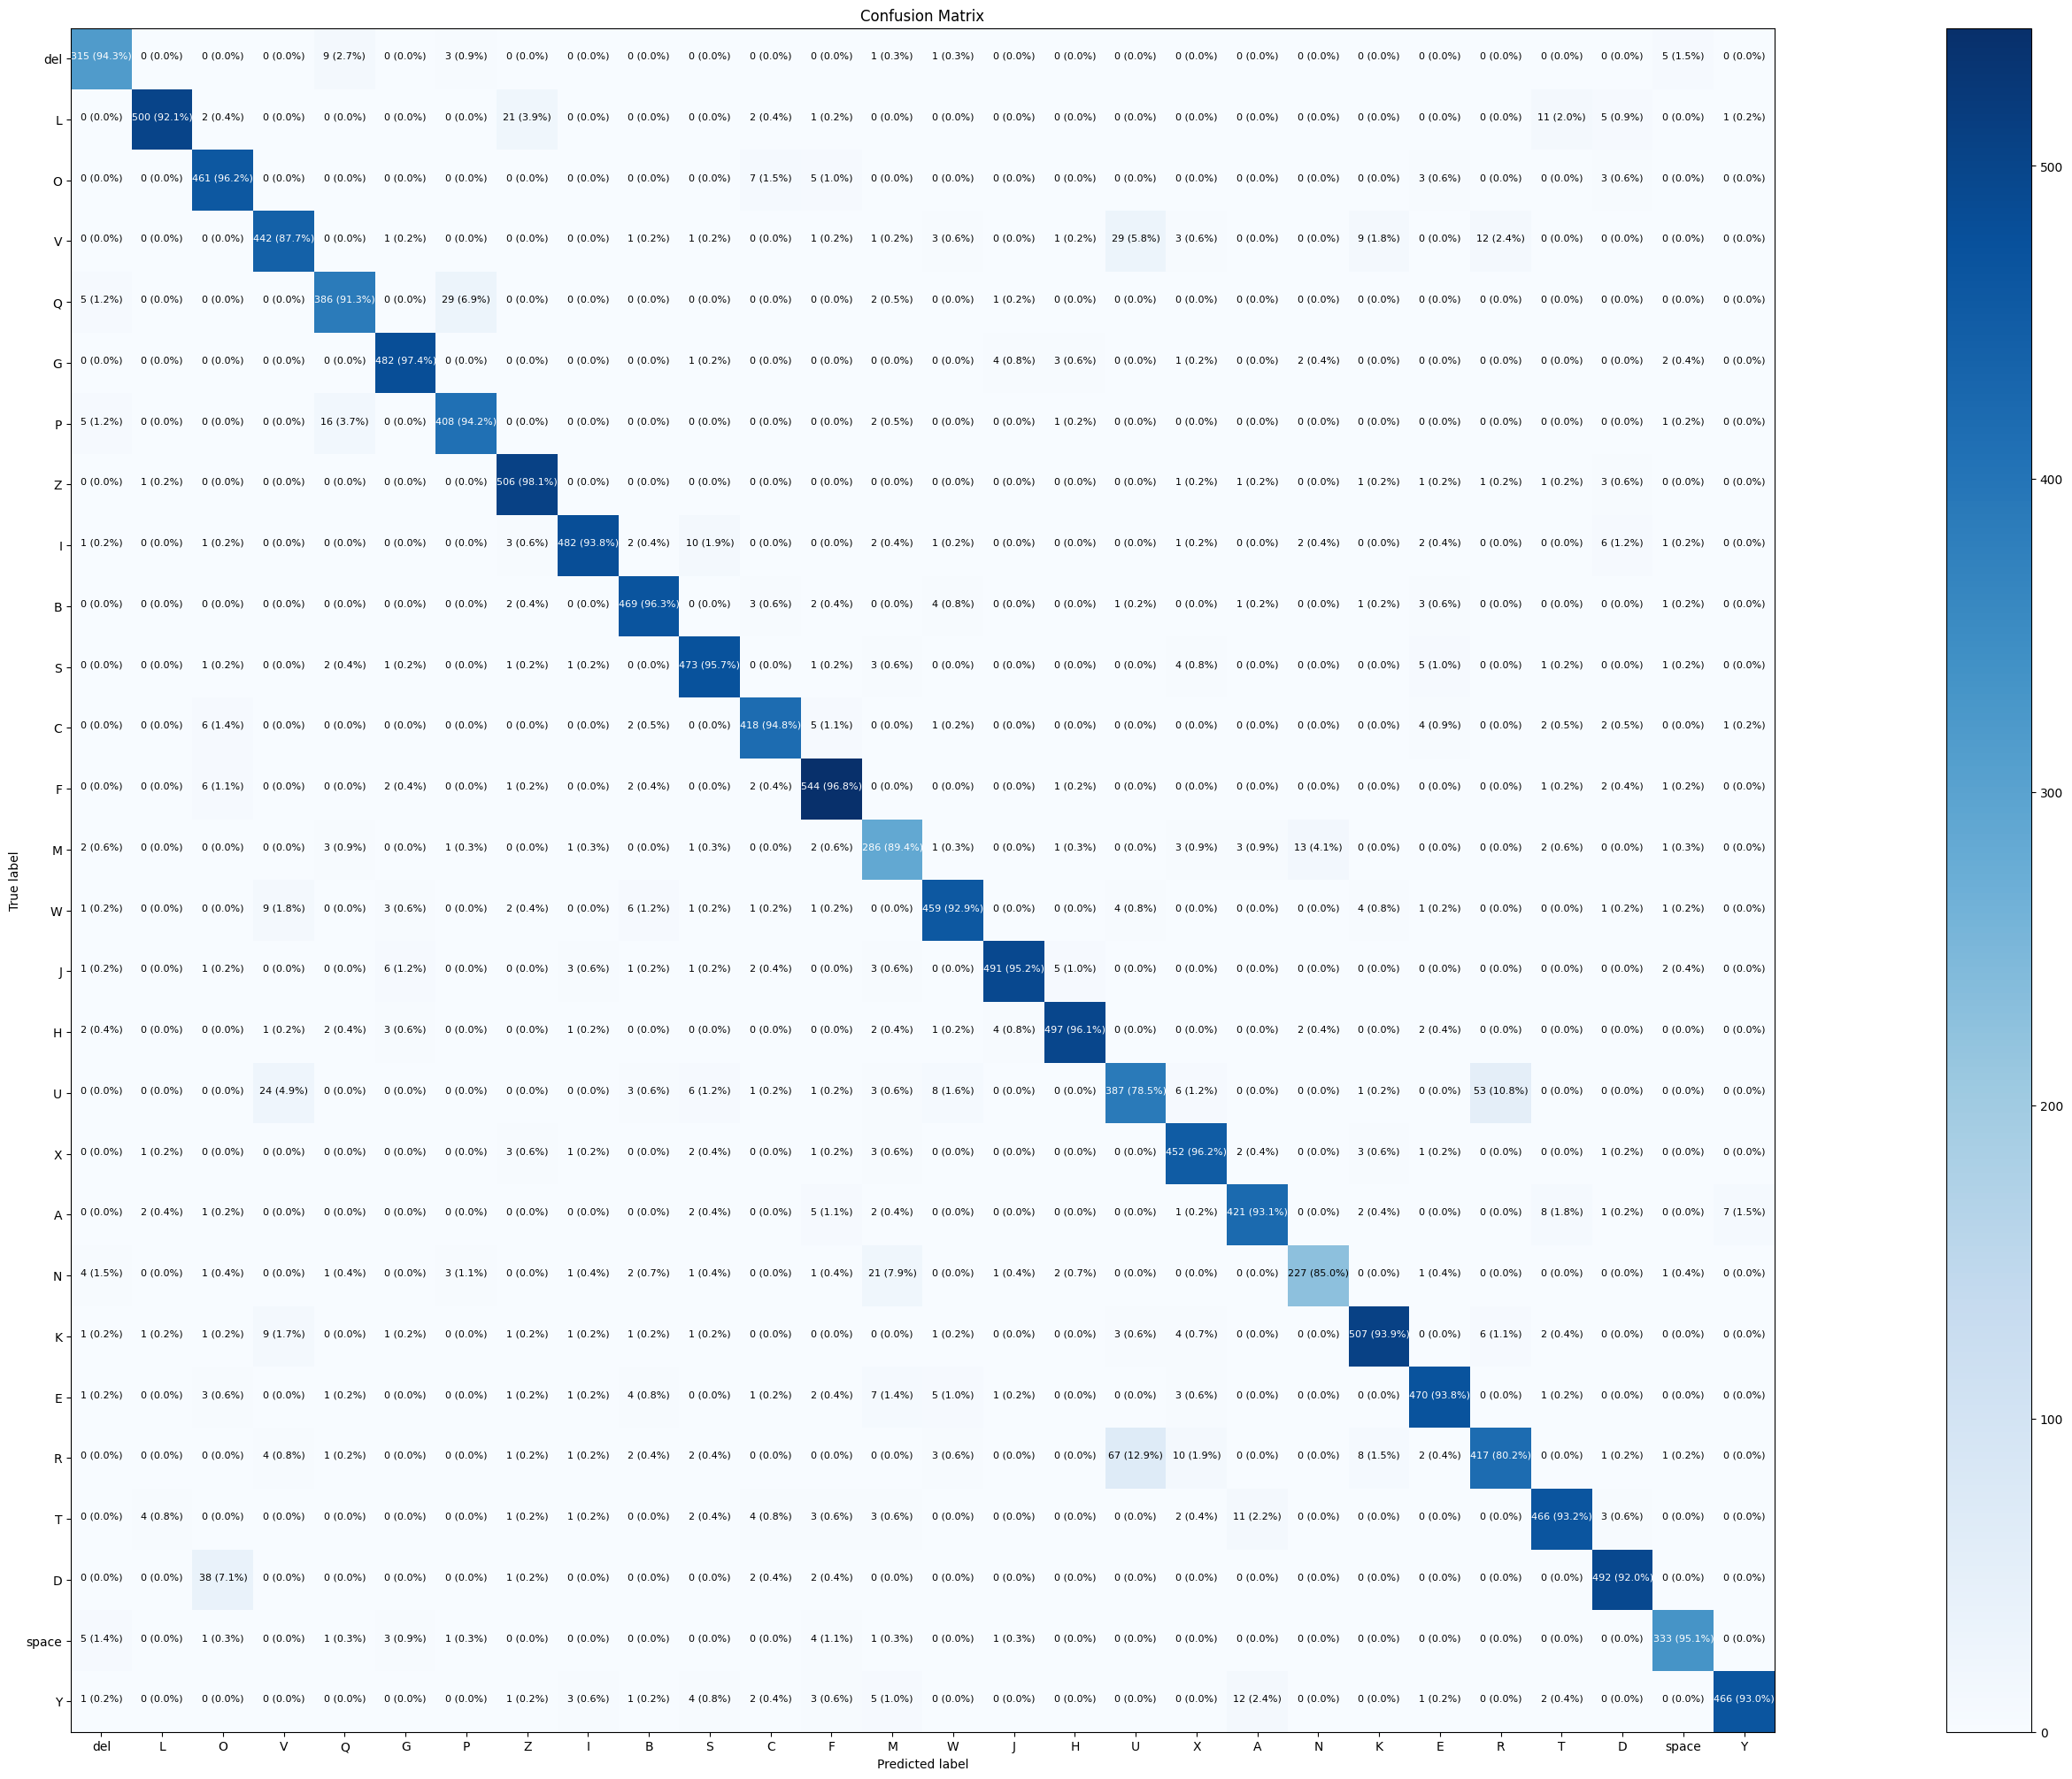

In [ ]:
word_labels = ['del','L','O','V','Q','G','P','Z','I','B',
               'S','C','F','M','W','J','H','U','X',
               'A','N','K','E','R','T','D',
               'space','Y']
make_confusion_matrix(y_test, y_pred1, classes=word_labels, figsize=(50, 25), text_size=8)

**Confusion Matrix for KNN model**

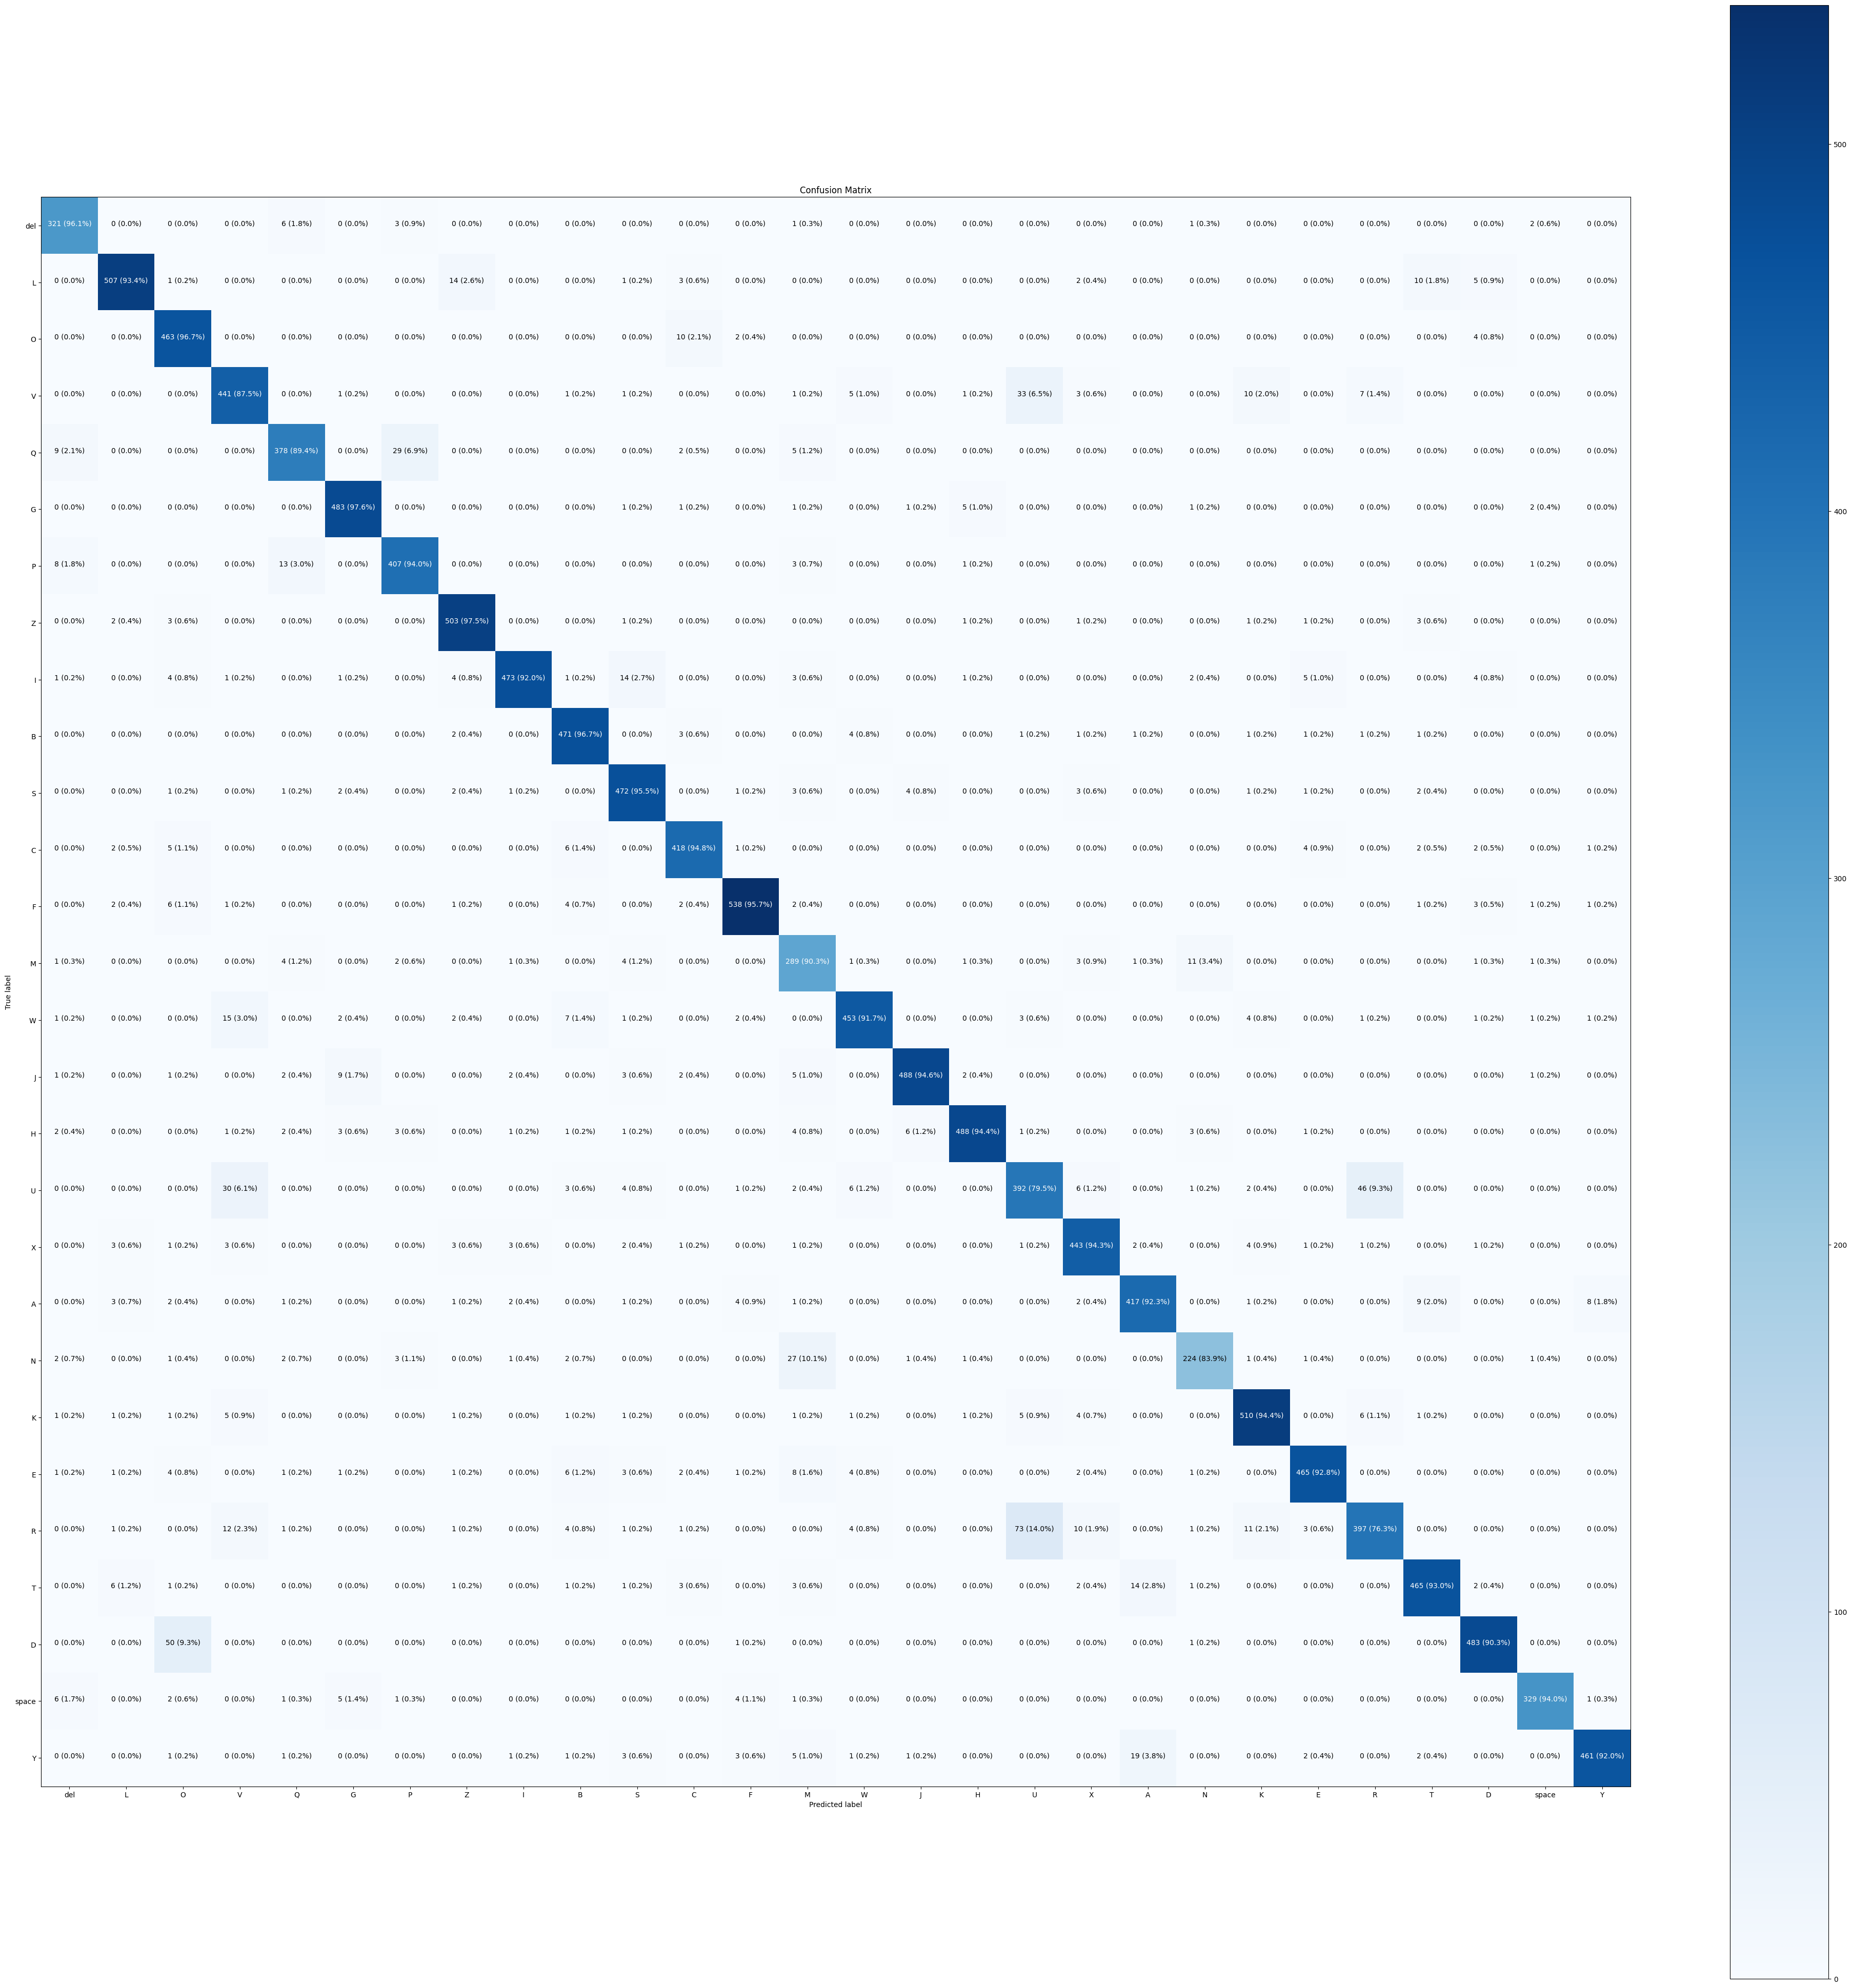

In [ ]:
make_confusion_matrix(y_test, y_pred2, classes=word_labels, figsize=(50, 50), text_size=10)

**Confusion matrix for naive bayes model**

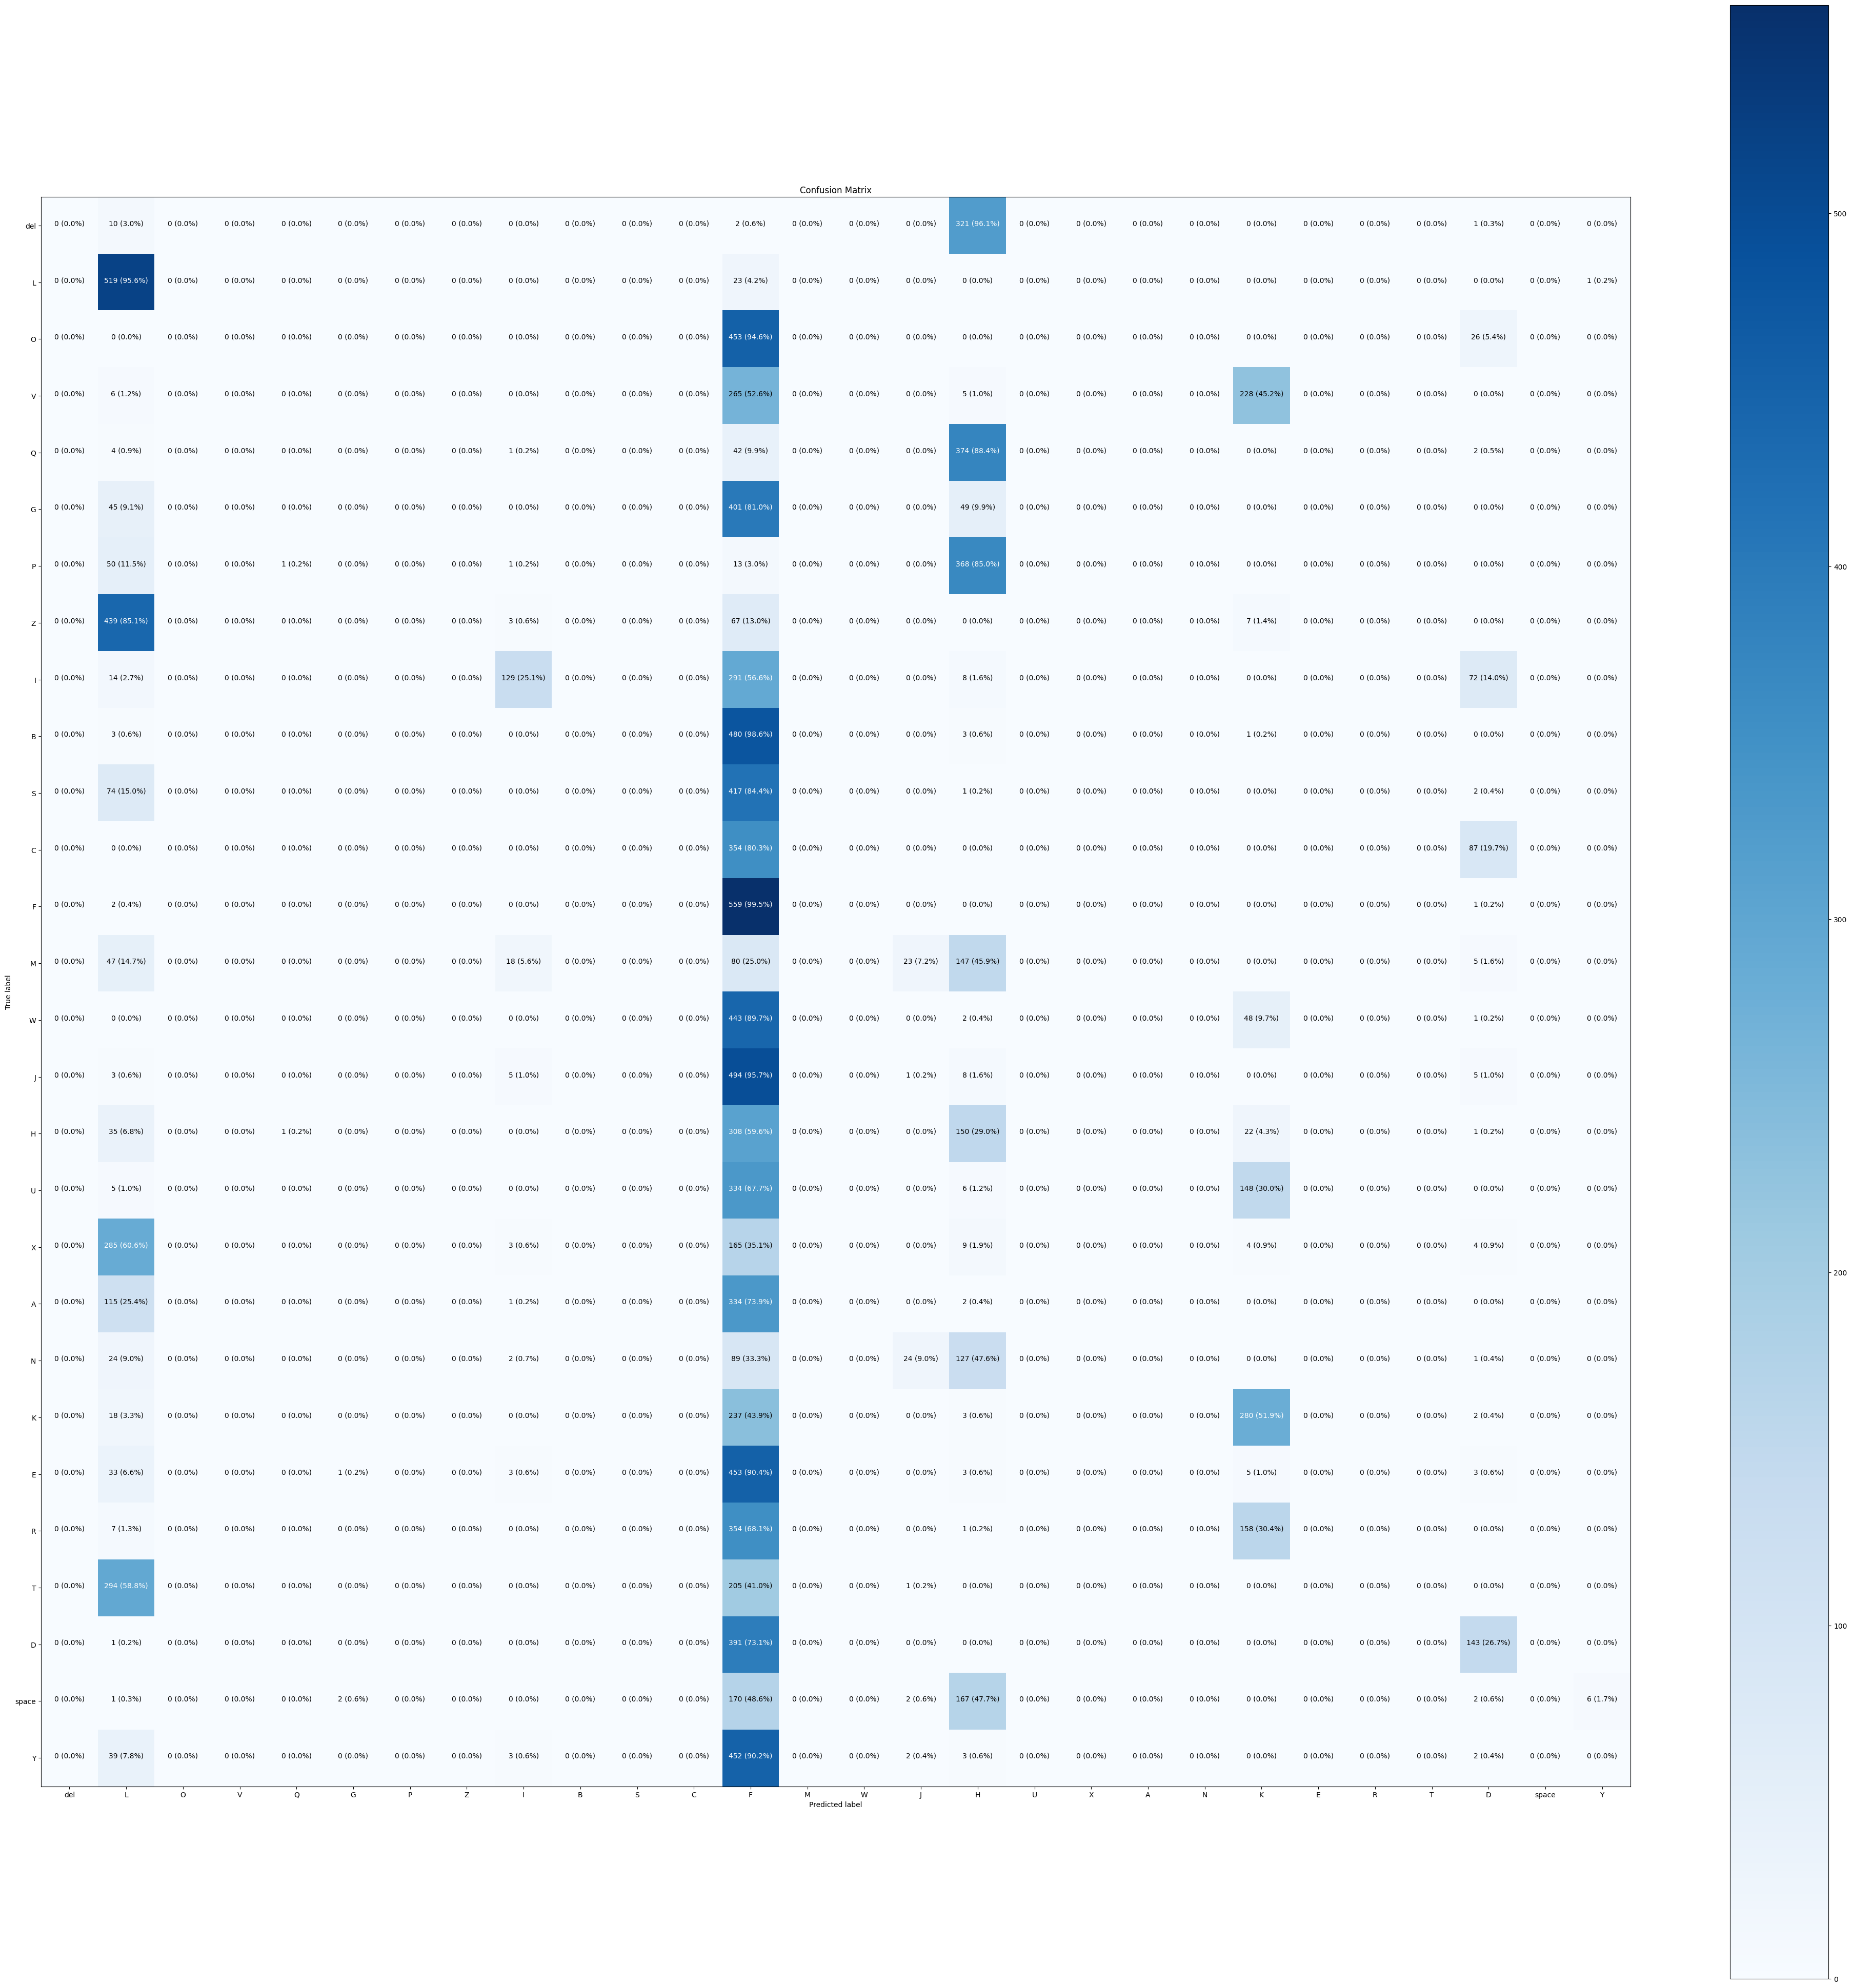

In [ ]:
make_confusion_matrix(y_test, y_pred3, classes=word_labels, figsize=(50, 50), text_size=10)

**Saving best model**

In [ ]:
# Saving Random forest models
import pickle
filename = '/content/drive/MyDrive/models/asl_randomforest_angleWithOrigin_model.sav'
pickle.dump(model1, open(filename, 'wb'))

## Building model for angles with Wrist(0 point)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/data/asl_cleaned_data/cleaned_ASL.parquet')
df = df[df['label'] != 'nothing']
df.reset_index(inplace=True, drop=True)
df.head()

label                                          file_path  x_hand_0  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.640012   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.703644   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.812010   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.584252   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.743570   

   y_hand_0  x_hand_1  y_hand_1  x_hand_2  y_hand_2  x_hand_3  y_hand_3  ...  \
0  0.549258  0.603969  0.613443  0.539320  0.666677  0.484856  0.713343  ...   
1  0.214589  0.659422  0.263398  0.619649  0.294278  0.587120  0.336895  ...   
2  0.453296  0.758869  0.396527  0.642238  0.356300  0.533390  0.369457  ...   
3  0.665317  0.553047  0.644940  0.469424  0.630440  0.393331  0.643162  ...   
4  0.308794  0.703851  0.249148  0.627094  0.206340  0.545086  0.207994  ...   

   x_hand_16  y_hand_16  x_hand_17  y_hand_17  x_hand_18  y_hand_18  \
0   0.549798   0.589359   0.476179   0.509092   0.495156   0.569426   
1   0.751583   0.180263   0.807003   0.166073   0.831242   0.183669   
2   0.423510   0.633702   0.540103   0.439028   0.471854   0.498762   
3   0.315942   0.835835   0.385209   0.678265   0.336830   0.730859   
4   0.445949   0.420815   0.538324   0.290418   0.490410   0.336814   

   x_hand_19  y_hand_19  x_hand_20  y_hand_20  
0   0.537279   0.578356   0.552594   0.567106  
1   0.827715   0.193476   0.815729   0.193224  
2   0.453077   0.546022   0.433401   0.588540  
3   0.329206   0.779250   0.324796   0.819947  
4   0.470234   0.381444   0.450705   0.422993  

[5 rows x 44 columns]

In [ ]:
df.describe()

x_hand_0      y_hand_0      x_hand_1      y_hand_1      x_hand_2  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.538310      0.714816      0.610797      0.665630      0.645952   
std        0.176500      0.167801      0.156564      0.158317      0.150708   
min       -0.021446     -0.014129      0.013245      0.005527      0.036234   
25%        0.410091      0.605794      0.500804      0.559916      0.542843   
50%        0.535421      0.737100      0.614723      0.682644      0.654849   
75%        0.667342      0.845542      0.726660      0.786670      0.757919   
max        1.132922      1.186156      1.116041      1.148898      1.034964   

           y_hand_2      x_hand_3      y_hand_3      x_hand_4      y_hand_4  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.588980      0.620220      0.529426      0.581240      0.497761   
std        0.151767      0.165256      0.155395      0.191059      0.165248   
min        0.040098      0.045038      0.019571     -0.011748      0.001808   
25%        0.484055      0.506970      0.420118      0.443495      0.381124   
50%        0.600253      0.628966      0.532883      0.583092      0.495999   
75%        0.702415      0.746703      0.644502      0.729110      0.617374   
max        1.003168      1.036638      1.071841      1.071611      1.125050   

       ...     x_hand_16     y_hand_16     x_hand_17     y_hand_17  \
count  ...  66003.000000  66003.000000  66003.000000  66003.000000   
mean   ...      0.508389      0.529299      0.431846      0.531497   
std    ...      0.171368      0.190680      0.161059      0.154965   
min    ...     -0.003885     -0.031801     -0.066506      0.012278   
25%    ...      0.383737      0.397751      0.313012      0.424169   
50%    ...      0.505853      0.543548      0.429916      0.536587   
75%    ...      0.635724      0.677043      0.546558      0.644437   
max    ...      1.111401      1.302500      1.113407      1.059298   

          x_hand_18     y_hand_18     x_hand_19     y_hand_19     x_hand_20  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.423348      0.485704      0.439664      0.508372      0.451944   
std        0.166269      0.159702      0.175258      0.172860      0.184705   
min       -0.087267      0.014269     -0.049761     -0.005101     -0.059705   
25%        0.298153      0.369796      0.305751      0.377646      0.311389   
50%        0.419091      0.484334      0.434552      0.514464      0.446124   
75%        0.544378      0.600790      0.570029      0.642207      0.588660   
max        1.055238      1.130474      1.079368      1.199027      1.101631   

          y_hand_20  
count  66003.000000  
mean       0.526936  
std        0.191156  
min       -0.006835  
25%        0.385479  
50%        0.540036  
75%        0.678878  
max        1.271680  

[8 rows x 42 columns]

**Getting angles with wrist or point 0 in mediapipe**

In [ ]:
import collections
import math

def aligned_angle(x1, y1, x2, y2):
    angle = math.degrees(math.atan2(y2- y1, x2-x1))
    if angle < 0:
        return (angle + 360)/360
    return angle/360

angle_with_origin = collections.defaultdict(list)
for i in range(len(df)):
    for j in range(1, 21):
        angle_with_origin[f'angle_{j}'].append(aligned_angle(df[f'x_hand_0'][i], df[f'y_hand_0'][i], df[f'x_hand_{j}'][i], df[f'y_hand_{j}'][i]))
for poi in angle_with_origin:
    print(angle_with_origin[poi])
    break

[0.33143448253355073, 0.3671583791101852, 0.6302527697147908, 0.592066137316427, 0.656499271969795, 0.6072110587492685, 0.5139728095846565, 0.565184831195931, 0.6627288783783917, 0.6134758159476318, 0.5594820047992689, 0.570110241950785, 0.9684863971414234, 0.6252365377498682, 0.5263141787245614, 0.5590764046486055, 0.9530066914224027, 0.5648721644299844, 0.5040128742922706, 0.5887388224506713, 0.5590132874289039, 0.4818010926187475, 0.5620606305256077, 0.622799224764678, 0.6564711462936632, 0.5606418118970921, 0.4636849498968638, 0.6056010208853663, 0.5595155485159249, 0.6468042134576963, 0.6397583293911685, 0.6737760196562148, 0.5524228923984627, 0.3383275551975135, 0.6893964579798968, 0.6753369179856842, 0.5471463563038621, 0.6617493696582977, 0.5963014390997434, 0.629007403575997, 0.24927752562762623, 0.5998846424182716, 0.5984426775924331, 0.743707784280105, 0.20115853793121916, 0.5430630279942469, 0.5473445026537721, 0.573196479776306, 0.49259366545314615, 0.6412307331768436, 0.6

In [ ]:
new_df = df[['label', 'file_path']]
for poi in angle_with_origin:
    new_df[poi] = angle_with_origin[poi]
new_df.head()

label                                          file_path   angle_1  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.331434   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.367158   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.630253   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.592066   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.656499   

    angle_2   angle_3   angle_4   angle_5   angle_6   angle_7   angle_8  ...  \
0  0.362819  0.370549  0.370242  0.474570  0.411534  0.374895  0.353859  ...   
1  0.379186  0.371148  0.366581  0.797553  0.761259  0.673586  0.594227  ...   
2  0.582613  0.546520  0.524376  0.592279  0.528651  0.485488  0.454312  ...   
3  0.546930  0.518387  0.498322  0.566053  0.501755  0.453616  0.420131  ...   
4  0.614821  0.574788  0.551196  0.604234  0.579155  0.571217  0.565445  ...   

   angle_11  angle_12  angle_13  angle_14  angle_15  angle_16  angle_17  \
0  0.402486  0.400322  0.522251  0.452015  0.424480  0.433429  0.538264   
1  0.771414  0.655198  0.894788  0.893561  0.903855  0.901101  0.930153   
2  0.462775  0.429942  0.534191  0.487061  0.453720  0.430810  0.508344   
3  0.442162  0.409269  0.512950  0.470555  0.434966  0.409897  0.489661   
4  0.488281  0.458659  0.540904  0.500650  0.466978  0.442707  0.514211   

   angle_18  angle_19  angle_20  
0  0.477983  0.456071  0.467946  
1  0.962163  0.973174  0.970022  
2  0.478853  0.459764  0.445396  
3  0.458786  0.433136  0.414461  
4  0.482456  0.458654  0.440826  

[5 rows x 22 columns]

In [ ]:
new_df.shape

(66003, 22)

In [ ]:
new_df.describe()

angle_1       angle_2       angle_3       angle_4       angle_5  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.779556      0.794588      0.761923      0.731778      0.763871   
std        0.263596      0.192588      0.174002      0.168556      0.099573   
min        0.000009      0.000025      0.000006      0.000057      0.000118   
25%        0.810371      0.785480      0.740320      0.698345      0.716246   
50%        0.882829      0.852335      0.801833      0.756536      0.793021   
75%        0.925347      0.897303      0.861151      0.833975      0.824866   
max        0.999990      0.999995      0.999967      0.999926      0.999995   

            angle_6       angle_7       angle_8       angle_9      angle_10  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.743432      0.734452      0.733256      0.730366      0.715102   
std        0.130574      0.146655      0.153352      0.088738      0.120933   
min        0.000207      0.000096      0.000104      0.001998      0.000221   
25%        0.710173      0.703103      0.707250      0.688031      0.675522   
50%        0.784590      0.783078      0.782642      0.753696      0.754585   
75%        0.812063      0.811932      0.818178      0.785019      0.781261   
max        0.999983      0.999906      0.998536      0.998242      0.999989   

           angle_11      angle_12      angle_13      angle_14      angle_15  \
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000   
mean       0.713730      0.718346      0.696547      0.688424      0.689690   
std        0.139180      0.151203      0.084798      0.109880      0.126531   
min        0.000028      0.000990      0.000043      0.002424      0.000424   
25%        0.674041      0.683550      0.653524      0.638236      0.641676   
50%        0.758921      0.762713      0.717364      0.720888      0.727580   
75%        0.790582      0.805150      0.748596      0.752269      0.758140   
max        0.999234      0.999958      0.996697      0.996113      0.997347   

           angle_16      angle_17      angle_18      angle_19      angle_20  
count  66003.000000  66003.000000  66003.000000  66003.000000  66003.000000  
mean       0.693353      0.660136      0.663181      0.662410      0.660804  
std        0.138699      0.086553      0.103315      0.115117      0.123308  
min        0.000684      0.000127      0.000427      0.000628      0.001001  
25%        0.650533      0.609266      0.599327      0.602120      0.604124  
50%        0.734212      0.673736      0.688122      0.690395      0.686450  
75%        0.765070      0.711780      0.723046      0.726518      0.727574  
max        0.999766      0.999181      0.999371      0.999935      0.999681

In [ ]:
# Saving data in file
# new_df.to_parquet('/content/drive/MyDrive/data/asl_cleaned_data/angleWithOrigin.parquet')

In [ ]:
# Label encoding
word_labels = {'del':0,'L':1,'O':2,'V':3,'Q':4,'G':5,'P':6,'Z':7,'I':8,'B':9,
               'S':10,'C':11,'F':12,'M':13,'W':14,'J':15,'H':16,'U':17,'X':18,
               'A':19,'N':20,'K':21,'E':22,'R':23,'T':24,'D':25,
               'space':26,'Y':27}
new_df['results'] = new_df['label'].apply(lambda x:word_labels[x])
new_df.head()

label                                          file_path   angle_1  \
0   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.331434   
1   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.367158   
2   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.630253   
3   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.592066   
4   del  /content/asl-alphabet/asl_alphabet_train/asl_a...  0.656499   

    angle_2   angle_3   angle_4   angle_5   angle_6   angle_7   angle_8  ...  \
0  0.362819  0.370549  0.370242  0.474570  0.411534  0.374895  0.353859  ...   
1  0.379186  0.371148  0.366581  0.797553  0.761259  0.673586  0.594227  ...   
2  0.582613  0.546520  0.524376  0.592279  0.528651  0.485488  0.454312  ...   
3  0.546930  0.518387  0.498322  0.566053  0.501755  0.453616  0.420131  ...   
4  0.614821  0.574788  0.551196  0.604234  0.579155  0.571217  0.565445  ...   

   angle_12  angle_13  angle_14  angle_15  angle_16  angle_17  angle_18  \
0  0.400322  0.522251  0.452015  0.424480  0.433429  0.538264  0.477983   
1  0.655198  0.894788  0.893561  0.903855  0.901101  0.930153  0.962163   
2  0.429942  0.534191  0.487061  0.453720  0.430810  0.508344  0.478853   
3  0.409269  0.512950  0.470555  0.434966  0.409897  0.489661  0.458786   
4  0.458659  0.540904  0.500650  0.466978  0.442707  0.514211  0.482456   

   angle_19  angle_20  results  
0  0.456071  0.467946        0  
1  0.973174  0.970022        0  
2  0.459764  0.445396        0  
3  0.433136  0.414461        0  
4  0.458654  0.440826        0  

[5 rows x 23 columns]

In [ ]:
new_df.columns

Index(['label', 'file_path', 'angle_1', 'angle_2', 'angle_3', 'angle_4',
       'angle_5', 'angle_6', 'angle_7', 'angle_8', 'angle_9', 'angle_10',
       'angle_11', 'angle_12', 'angle_13', 'angle_14', 'angle_15', 'angle_16',
       'angle_17', 'angle_18', 'angle_19', 'angle_20', 'results'],
      dtype='object')

**Splitting data into training and testing data**

In [ ]:
from sklearn.model_selection import train_test_split
col_lis = ['angle_1','angle_2','angle_3','angle_4',
           'angle_5', 'angle_6', 'angle_7', 'angle_8', 'angle_9',
           'angle_10', 'angle_11', 'angle_12', 'angle_13', 'angle_14',
           'angle_15','angle_16', 'angle_17', 'angle_18', 'angle_19',
           'angle_20']
X_train, X_test, y_train, y_test = train_test_split(
    new_df[col_lis],new_df['results'],test_size=0.2,
    random_state=42,stratify=new_df.results
)

In [ ]:
print(X_train.shape, X_test.shape)

(52802, 20) (13201, 20)


In [ ]:
print(y_train.shape, y_test.shape)

(52802,) (13201,)


**Importing models from scikit-learn**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [ ]:
model1 = RandomForestClassifier(random_state=2023)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       334
           1       0.96      0.94      0.95       543
           2       0.93      0.97      0.95       479
           3       0.92      0.92      0.92       504
           4       0.97      0.96      0.97       423
           5       0.96      0.98      0.97       495
           6       0.97      0.98      0.97       433
           7       0.97      0.98      0.97       516
           8       0.91      0.86      0.88       514
           9       0.97      0.97      0.97       487
          10       0.93      0.90      0.92       494
          11       0.98      0.97      0.98       441
          12       0.97      0.95      0.96       562
          13       0.80      0.87      0.83       320
          14       0.94      0.92      0.93       494
          15       0.96      0.94      0.95       516
          16       0.97      0.97      0.97       517
          17       0.92    

In [ ]:
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       334
           1       0.94      0.95      0.94       543
           2       0.91      0.97      0.94       479
           3       0.91      0.92      0.91       504
           4       0.97      0.96      0.97       423
           5       0.97      0.98      0.97       495
           6       0.96      0.97      0.97       433
           7       0.97      0.98      0.97       516
           8       0.86      0.87      0.86       514
           9       0.96      0.96      0.96       487
          10       0.93      0.92      0.93       494
          11       0.97      0.98      0.98       441
          12       0.97      0.95      0.96       562
          13       0.76      0.79      0.77       320
          14       0.92      0.92      0.92       494
          15       0.95      0.95      0.95       516
          16       0.97      0.96      0.97       517
          17       0.90    

In [ ]:
model3 = MultinomialNB()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       334
           1       0.11      0.06      0.08       543
           2       0.00      0.00      0.00       479
           3       0.00      0.00      0.00       504
           4       0.00      0.00      0.00       423
           5       0.00      0.00      0.00       495
           6       0.00      0.00      0.00       433
           7       0.20      0.46      0.28       516
           8       0.00      0.00      0.00       514
           9       0.00      0.00      0.00       487
          10       0.00      0.00      0.00       494
          11       0.00      0.00      0.00       441
          12       0.05      0.98      0.10       562
          13       0.72      0.13      0.22       320
          14       0.00      0.00      0.00       494
          15       0.00      0.00      0.00       516
          16       0.00      0.00      0.00       517
          17       0.00    

In [ ]:
# Dscision Tree
model4 = DecisionTreeClassifier()
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       334
           1       0.94      0.91      0.92       543
           2       0.91      0.94      0.92       479
           3       0.85      0.83      0.84       504
           4       0.94      0.95      0.95       423
           5       0.95      0.96      0.95       495
           6       0.95      0.94      0.95       433
           7       0.97      0.96      0.96       516
           8       0.75      0.77      0.76       514
           9       0.93      0.94      0.93       487
          10       0.82      0.83      0.83       494
          11       0.97      0.97      0.97       441
          12       0.93      0.92      0.92       562
          13       0.73      0.78      0.75       320
          14       0.86      0.85      0.85       494
          15       0.92      0.92      0.92       516
          16       0.94      0.95      0.95       517
          17       0.86    

In [ ]:
model5 = LinearSVC(penalty='l1', dual=False, random_state=42)
model5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
print(classification_report(y_test, y_pred5))

In [ ]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       334
           1       0.60      0.94      0.74       543
           2       0.72      0.96      0.83       479
           3       0.81      0.49      0.61       504
           4       0.72      0.94      0.82       423
           5       0.78      0.94      0.85       495
           6       0.90      0.87      0.88       433
           7       0.69      0.93      0.79       516
           8       0.65      0.23      0.34       514
           9       0.93      0.82      0.87       487
          10       0.72      0.79      0.75       494
          11       0.75      0.74      0.74       441
          12       0.68      0.95      0.79       562
          13       0.52      0.41      0.46       320
          14       0.48      0.84      0.61       494
          15       0.89      0.69      0.78       516
          16       0.48      0.90      0.62       517
          17       0.77    

In [ ]:
model6 = LogisticRegression()
model6.fit(X_train, y_train)
y_pred6 = model6.predict(X_test)
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       334
           1       0.73      0.94      0.82       543
           2       0.73      0.93      0.82       479
           3       0.71      0.48      0.57       504
           4       0.81      0.91      0.85       423
           5       0.91      0.92      0.91       495
           6       0.93      0.84      0.88       433
           7       0.90      0.95      0.92       516
           8       0.53      0.52      0.53       514
           9       0.75      0.79      0.77       487
          10       0.81      0.82      0.81       494
          11       0.75      0.67      0.71       441
          12       0.88      0.93      0.91       562
          13       0.57      0.33      0.42       320
          14       0.78      0.75      0.76       494
          15       0.84      0.89      0.87       516
          16       0.90      0.88      0.89       517
          17       0.77    

### Confusion Matrix

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

**For Random Forest**

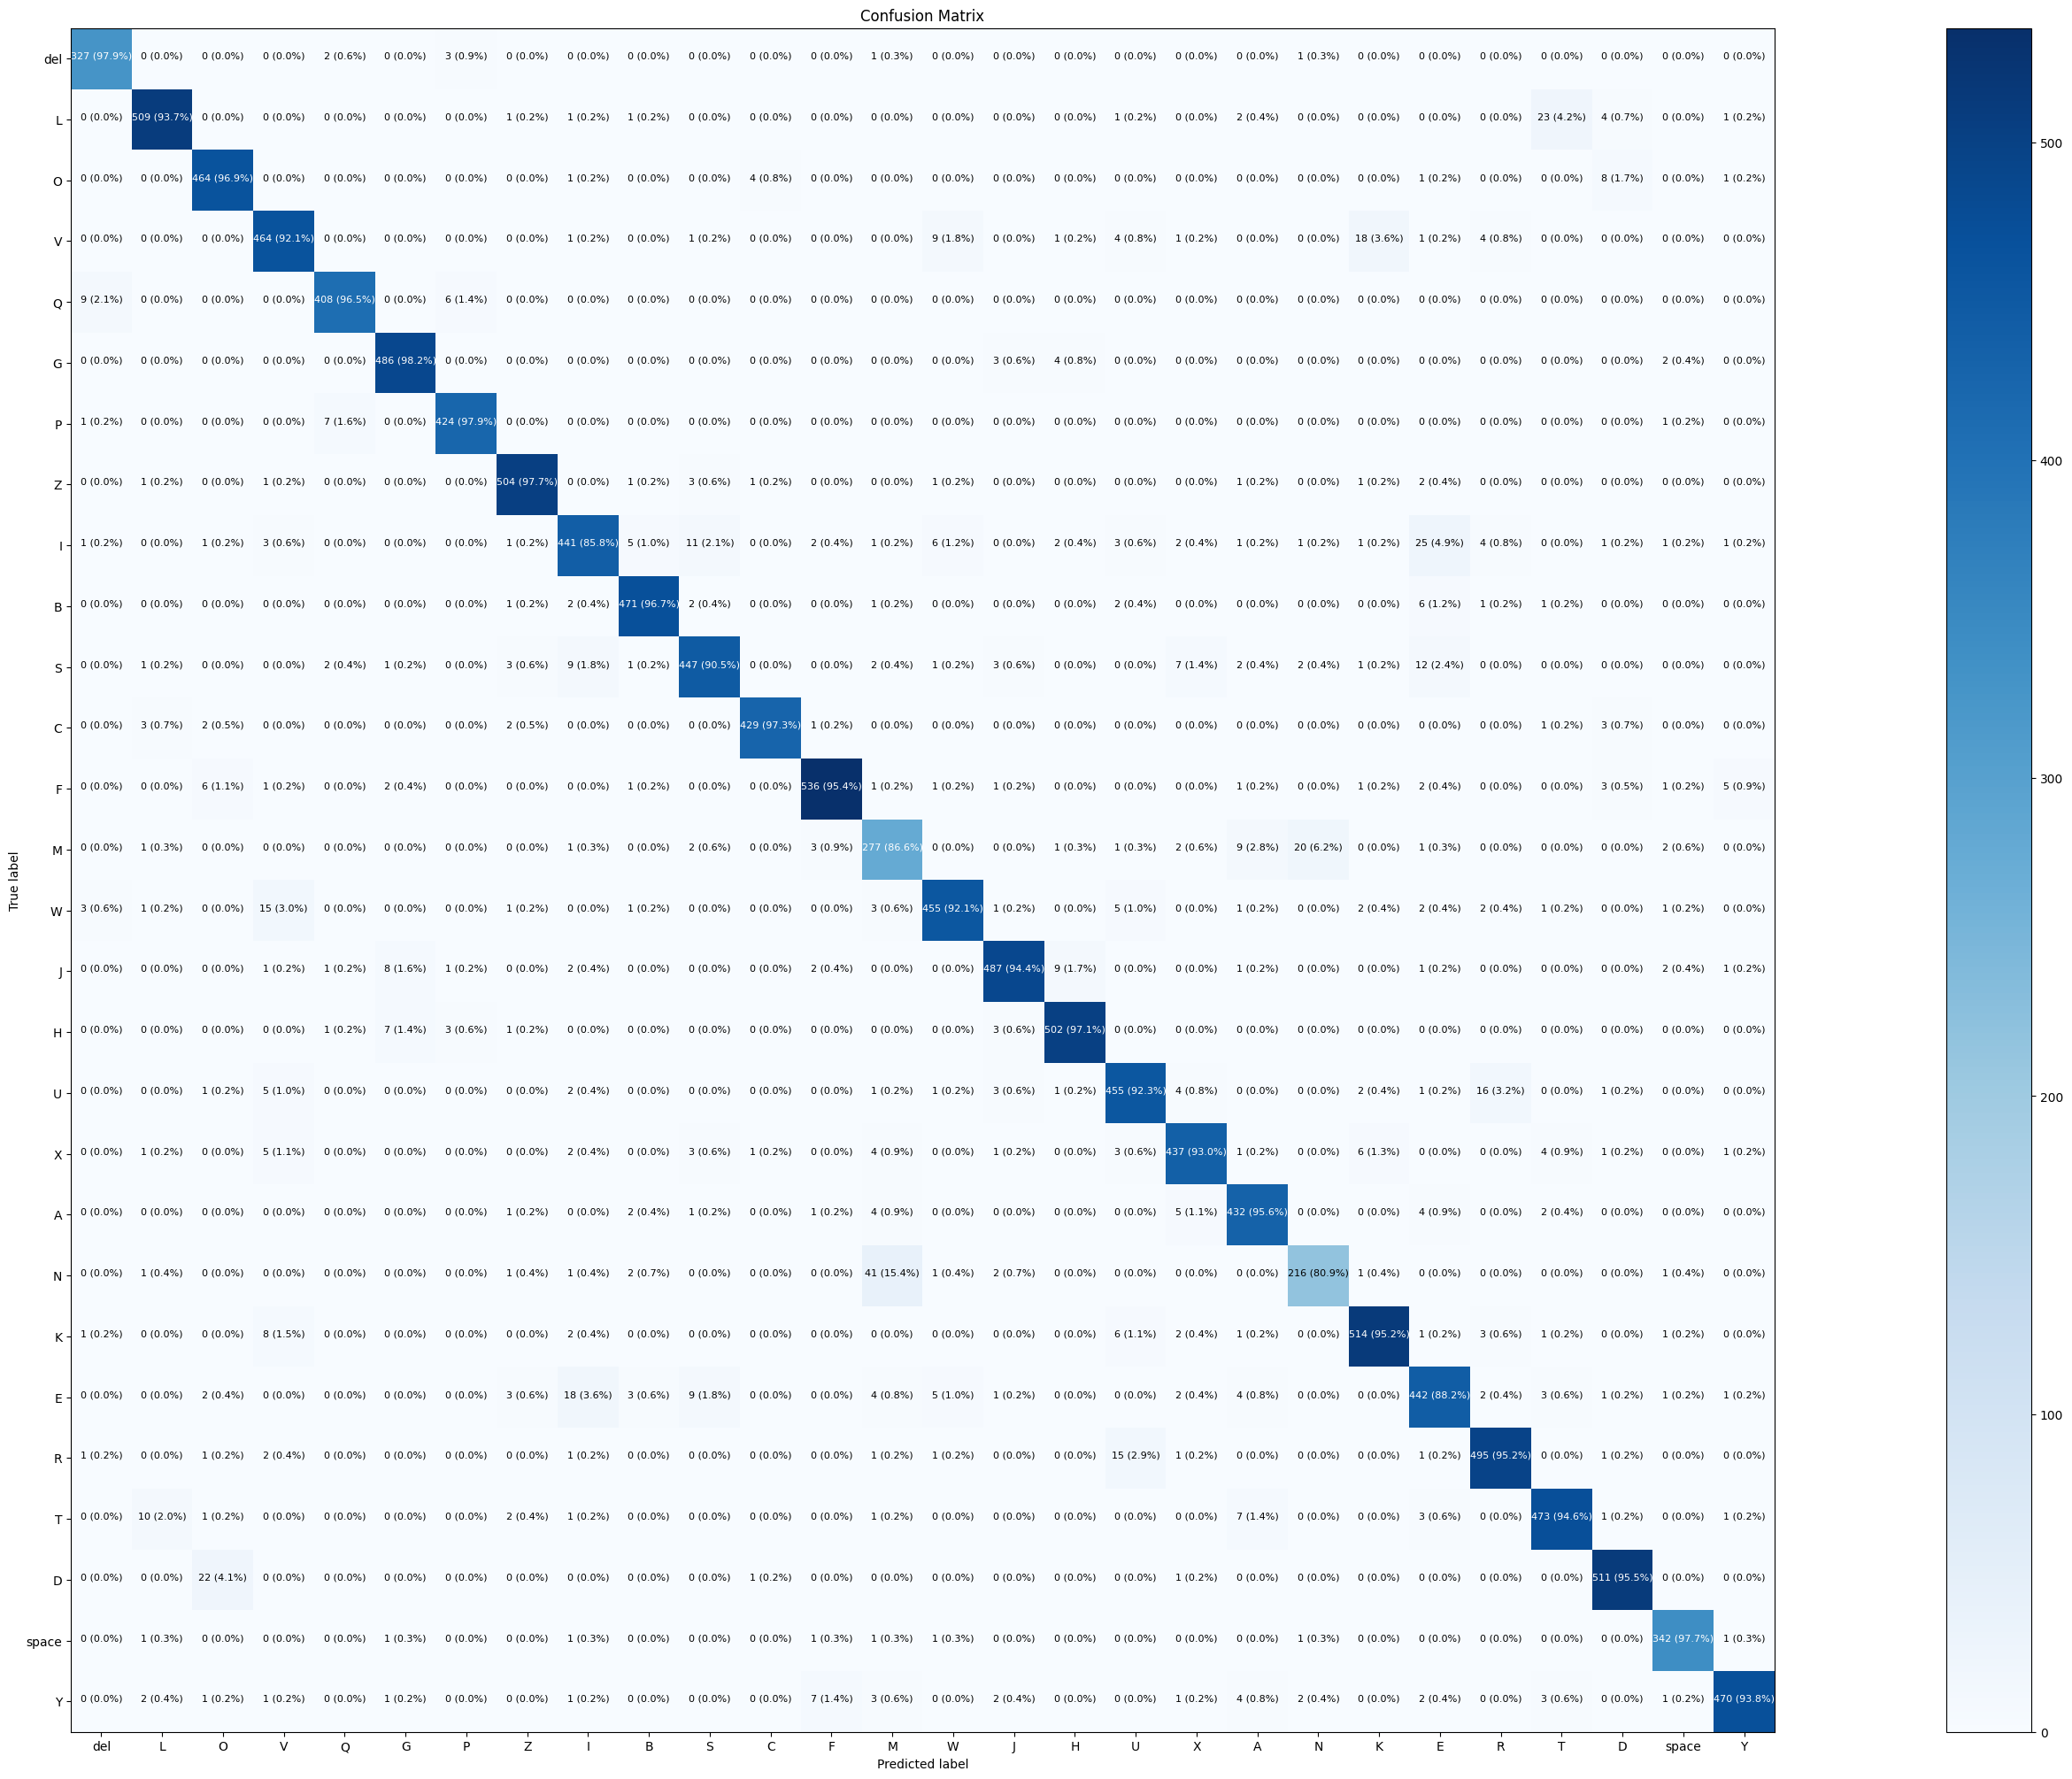

In [ ]:
word_labels = ['del','L','O','V','Q','G','P','Z','I','B',
               'S','C','F','M','W','J','H','U','X',
               'A','N','K','E','R','T','D',
               'space','Y']
make_confusion_matrix(y_test, y_pred1, classes=word_labels, figsize=(50, 25), text_size=8)

**For KNN**

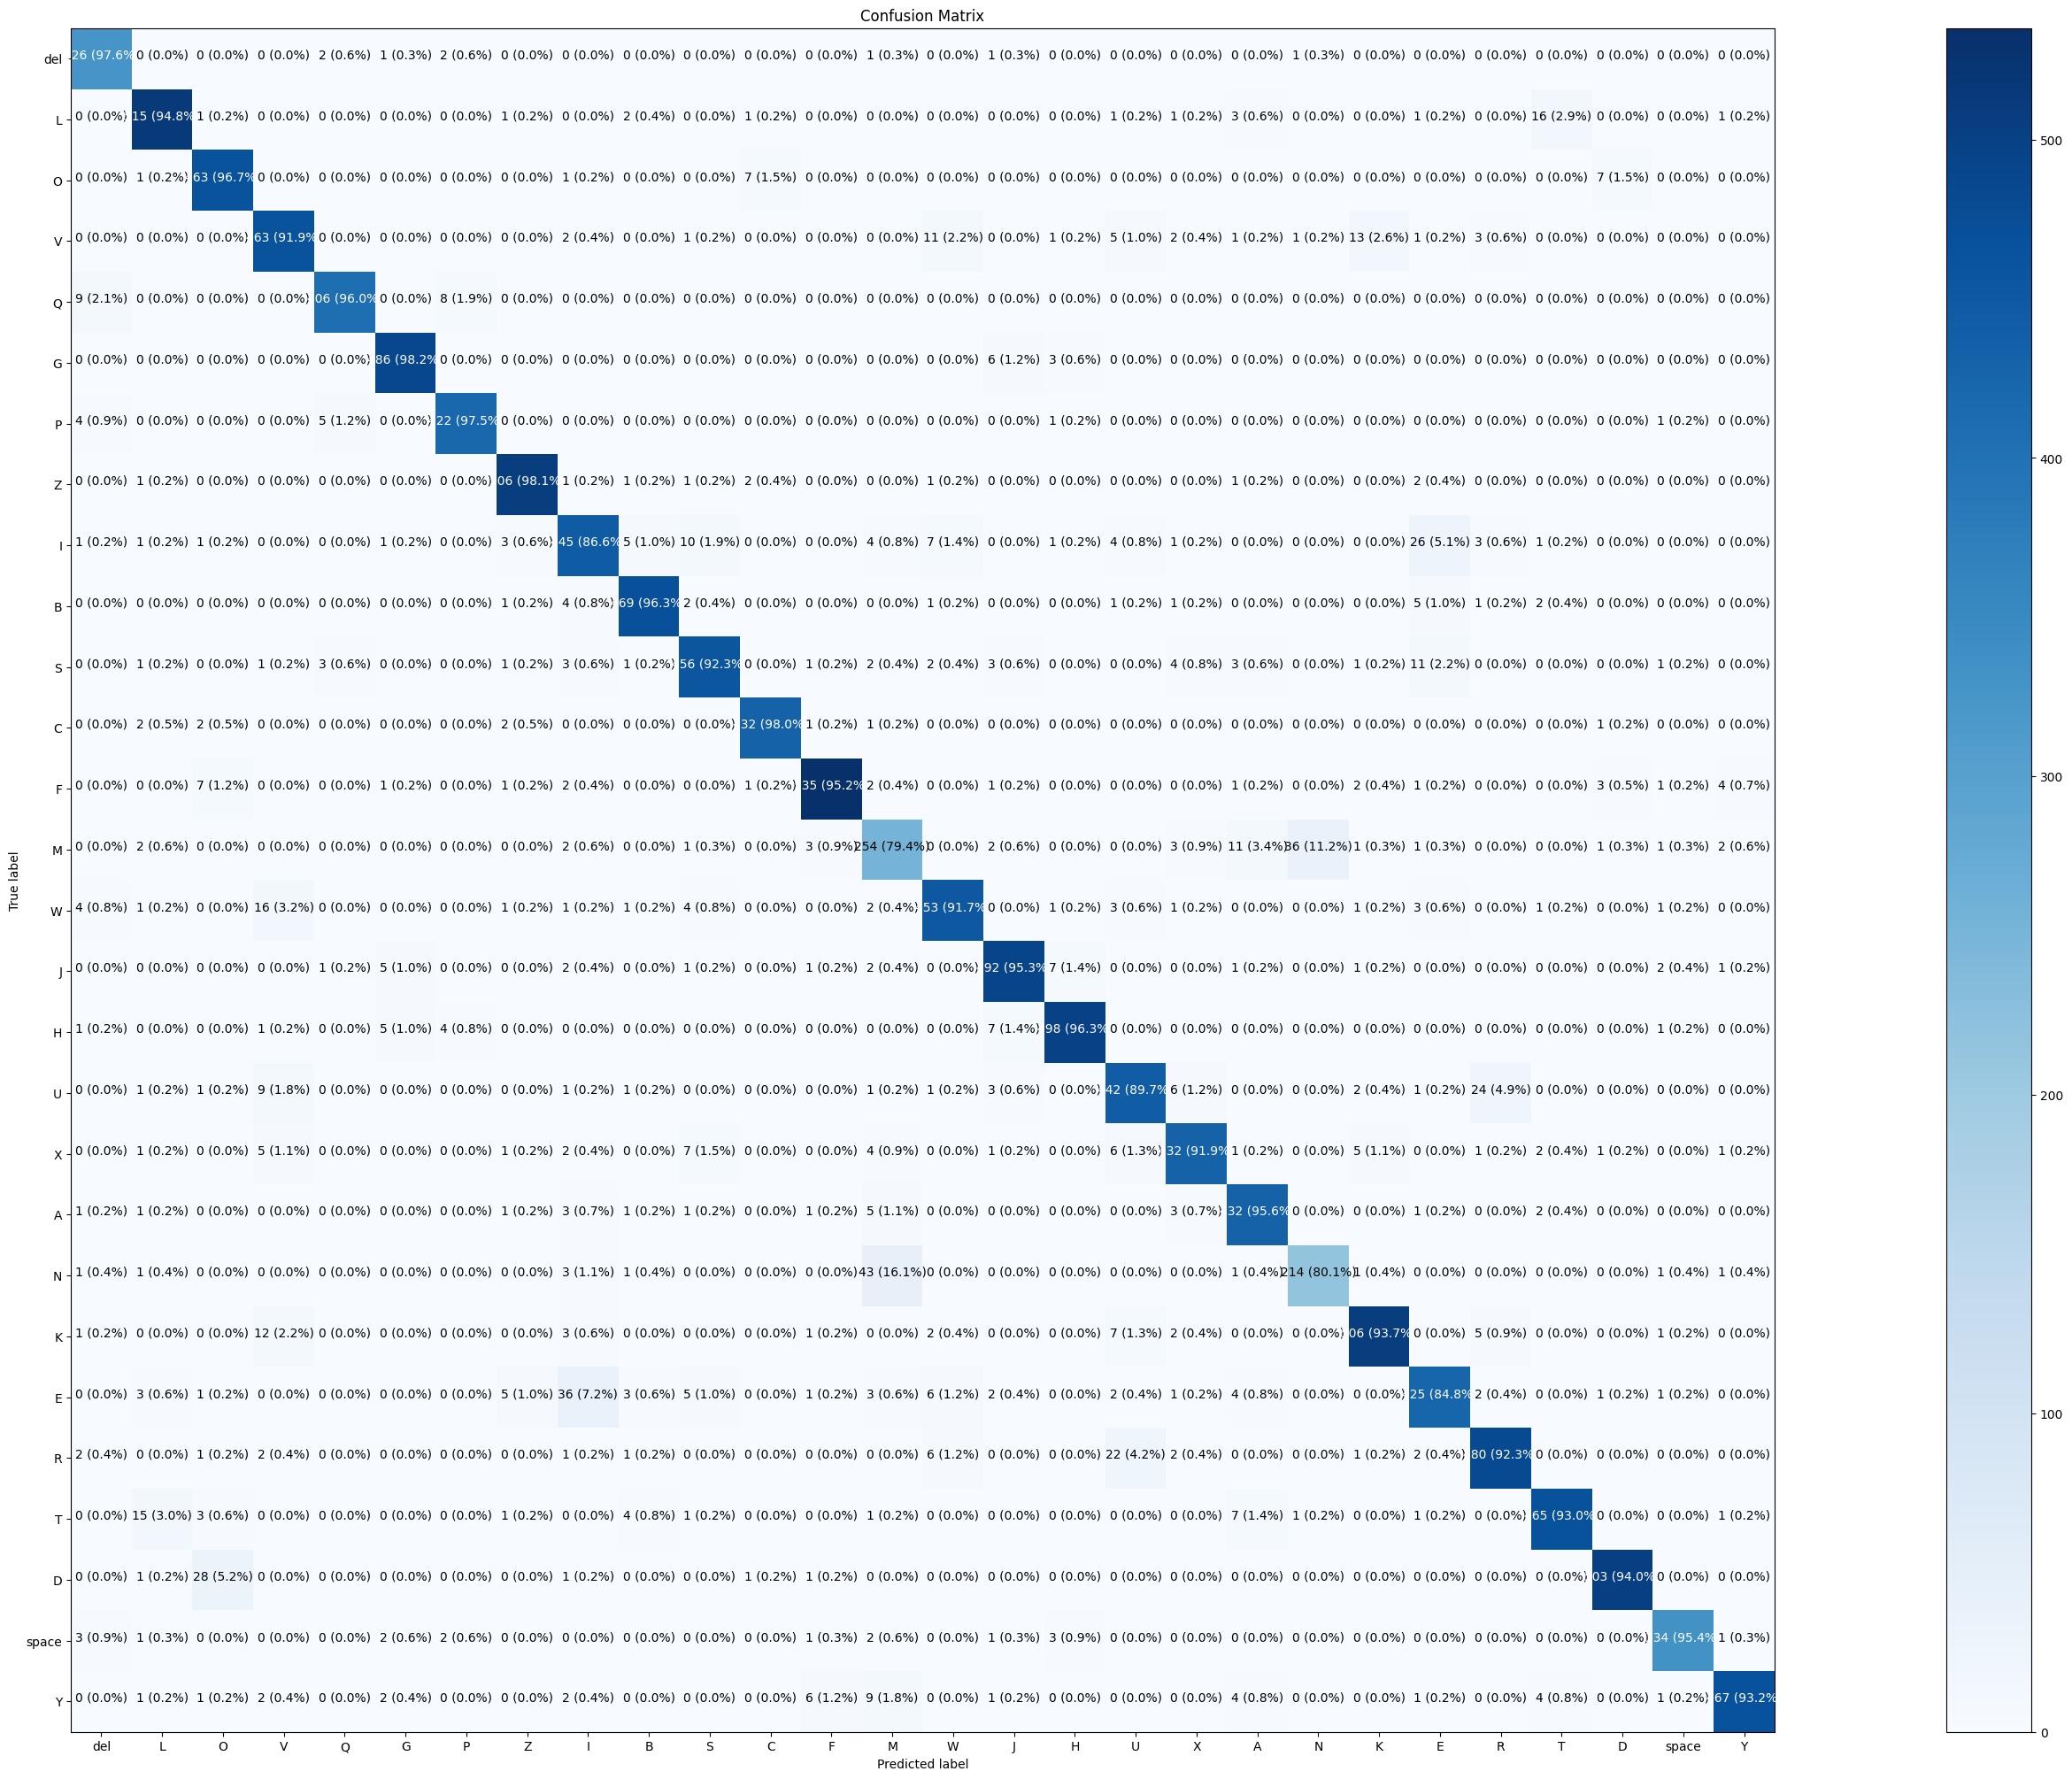

In [ ]:
make_confusion_matrix(y_test, y_pred2, classes=word_labels, figsize=(50, 25), text_size=10)

**For Naive Bayes**

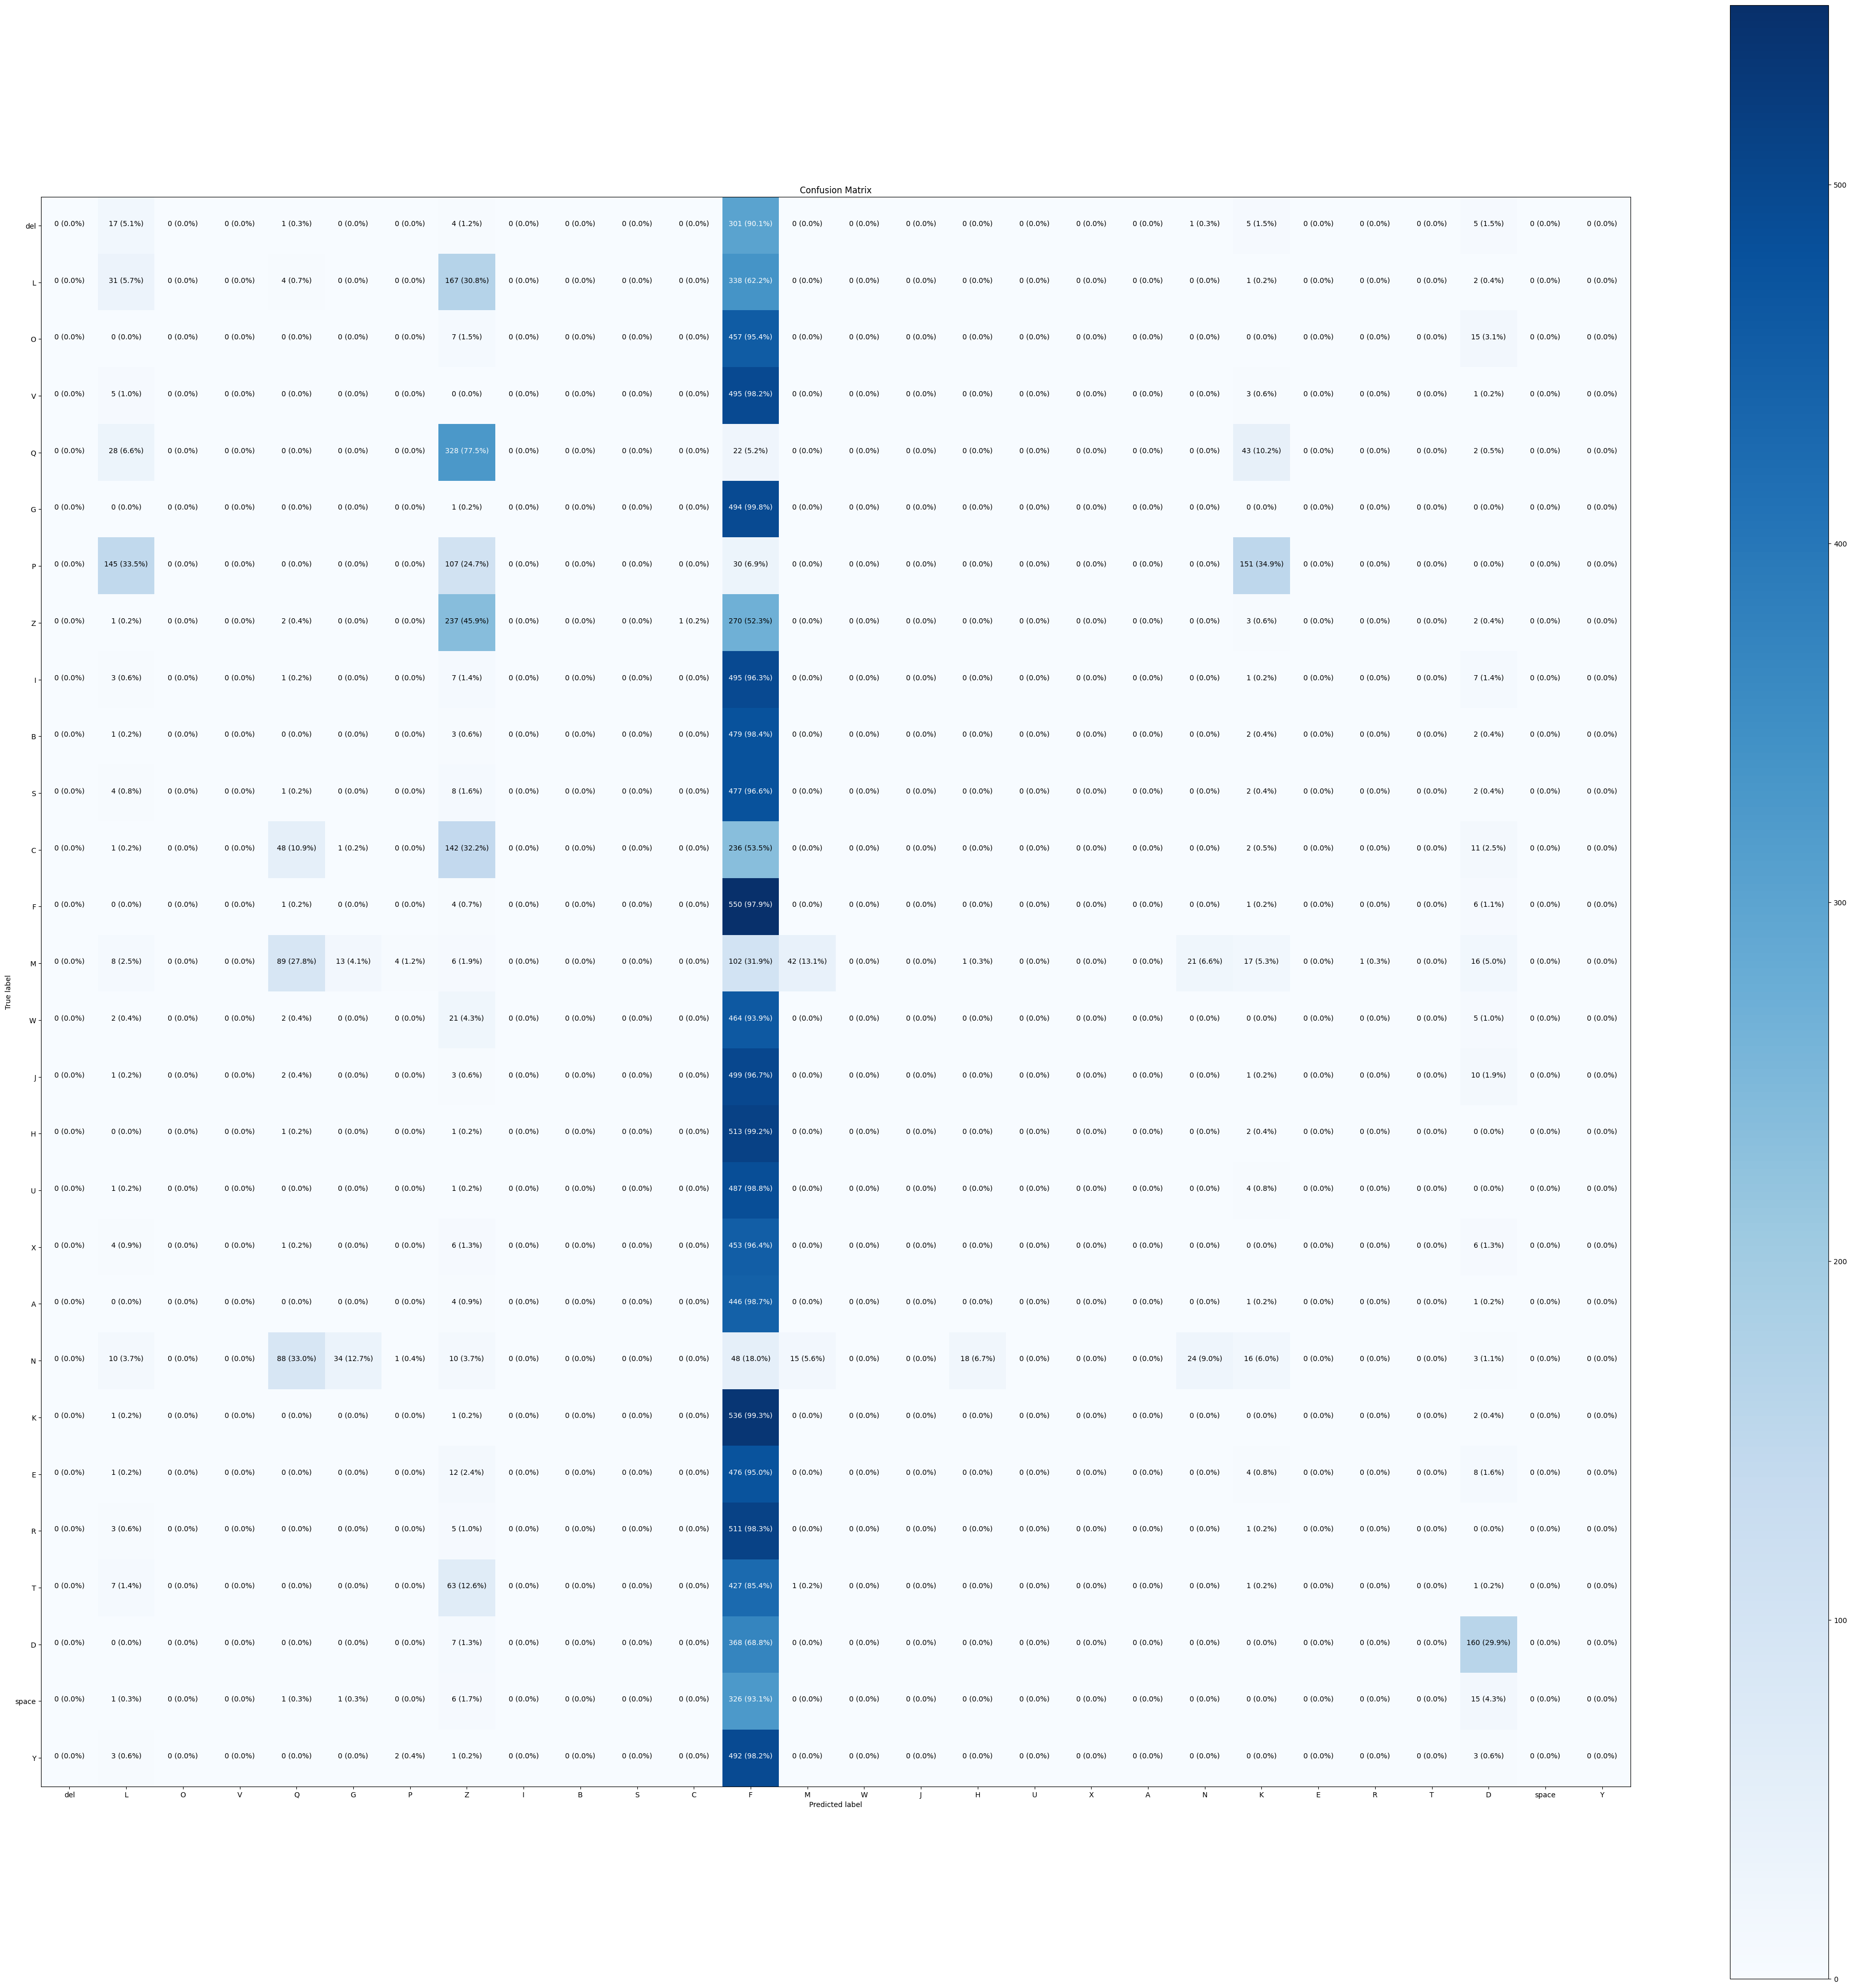

In [ ]:
make_confusion_matrix(y_test, y_pred3, classes=word_labels, figsize=(50, 50), text_size=10)

**Saving Model**

In [ ]:
# Saving Random forest modals
import pickle
filename = '/content/drive/MyDrive/models/asl_randomforest_angleWith0_model.sav'
pickle.dump(model1, open(filename, 'wb'))

## Validating Best Model with given test data

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import collections
import math
import pickle

def aligned_angle(x, y):
    angle = math.degrees(math.atan2(y, x))
    if angle < 0:
        return (angle + 360)/360
    return angle/360

word_labels = {'del':0,'L':1,'O':2,'V':3,'Q':4,'G':5,'P':6,'Z':7,'I':8,'B':9,
               'S':10,'C':11,'F':12,'M':13,'W':14,'J':15,'H':16,'U':17,'X':18,
               'A':19,'N':20,'K':21,'E':22,'R':23,'nothing':24,'T':25,'D':26,
               'space':27,'Y':28}
detector = handDetector()
labels = []
all_angels = collections.defaultdict(list)

for file_path in testData_path:
    img = plt.imread(file_path)
    lable_name = word_labels[file_path.split('/')[-1].split('_')[0]]
    found_angle = detector.findPosition(img)
    if len(found_angle) != 0 and lable_name != 24:
        labels.append(lable_name)
        for i in range(len(found_angle)):
            all_angels[f'angle_{i}'].append(aligned_angle(found_angle[i][0], found_angle[i][1]))


test_df = pd.DataFrame(all_angels)
test_df['results'] = labels

filename = '/content/drive/MyDrive/models/asl_randomforest_angleWithOrigin_model.sav'
model1 = pickle.load(open(filename, 'rb'))

y_predictTest1 = model1.predict(test_df[[f'angle_{i}' for i in range(len(all_angels))]])
print(classification_report(test_df['results'], y_predictTest1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          12       0.50      1.00      0.67         1
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          21       1.00      1.00      1.00         1
          22       1.00    

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import collections
import math
import pickle

def aligned_angle(x1, y1, x2, y2):
    angle = math.degrees(math.atan2(y2-y1, x2-x1))
    if angle < 0:
        return (angle + 360)/360
    return angle/360

word_labels = {'del':0,'L':1,'O':2,'V':3,'Q':4,'G':5,'P':6,'Z':7,'I':8,'B':9,
               'S':10,'C':11,'F':12,'M':13,'W':14,'J':15,'H':16,'U':17,'X':18,
               'A':19,'N':20,'K':21,'E':22,'R':23,'nothing':24,'T':25,'D':26,
               'space':27,'Y':28}
detector = handDetector()
labels = []
all_angels = collections.defaultdict(list)

for file_path in testData_path:
    img = plt.imread(file_path)
    lable_name = word_labels[file_path.split('/')[-1].split('_')[0]]
    found_angle = detector.findPosition(img)
    if len(found_angle) != 0 and lable_name != 24:
        labels.append(lable_name)
        for i in range(1, len(found_angle)):
            all_angels[f'angle_{i}'].append(aligned_angle(found_angle[0][0], found_angle[0][1], found_angle[i][0], found_angle[i][1]))


test_df = pd.DataFrame(all_angels)
test_df['results'] = labels

filename = '/content/drive/MyDrive/models/asl_randomforest_angleWith0_model.sav'
model = pickle.load(open(filename, 'rb'))

y_predictTest = model.predict(test_df[[f'angle_{i}' for i in range(1, 21)]])
print(classification_report(test_df['results'], y_predictTest))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         0
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
          21       1.00    

In [ ]:
all_angels.keys()

dict_keys(['angle_1', 'angle_2', 'angle_3', 'angle_4', 'angle_5', 'angle_6', 'angle_7', 'angle_8', 'angle_9', 'angle_10', 'angle_11', 'angle_12', 'angle_13', 'angle_14', 'angle_15', 'angle_16', 'angle_17', 'angle_18', 'angle_19', 'angle_20'])

In [ ]:
test_df

angle_0   angle_1   angle_2   angle_3   angle_4   angle_5   angle_6  \
0   0.189390  0.156959  0.123258  0.107395  0.118079  0.110366  0.083281   
1   0.138935  0.109944  0.087579  0.065983  0.050094  0.088396  0.082076   
2   0.127046  0.105570  0.089080  0.093222  0.118238  0.087424  0.081998   
3   0.164830  0.162568  0.157595  0.159194  0.177895  0.124815  0.083142   
4   0.076001  0.092642  0.109453  0.130514  0.154610  0.079169  0.121239   
5   0.131205  0.138345  0.141073  0.135087  0.126908  0.138087  0.117569   
6   0.159606  0.136943  0.121066  0.105942  0.090750  0.149845  0.171227   
7   0.163911  0.134965  0.104780  0.097991  0.122904  0.094700  0.072275   
8   0.149008  0.130584  0.120740  0.123207  0.136215  0.114242  0.120495   
9   0.182383  0.152536  0.124705  0.103598  0.083289  0.133948  0.096749   
10  0.190479  0.167317  0.148714  0.130508  0.109121  0.167700  0.132857   
11  0.079369  0.099174  0.121786  0.143920  0.167018  0.114747  0.171888   
12  0.170841  0.164650  0.162935  0.171585  0.187236  0.142771  0.111105   
13  0.180316  0.154630  0.126424  0.120336  0.127770  0.098240  0.072072   
14  0.175762  0.157134  0.139197  0.136181  0.137371  0.125303  0.096670   
15  0.183549  0.156452  0.128652  0.104808  0.086084  0.107516  0.084001   
16  0.139489  0.119983  0.105339  0.099064  0.099594  0.064758  0.093188   
17  0.156303  0.138442  0.123420  0.123212  0.137820  0.104961  0.079502   
18  0.193708  0.169600  0.142897  0.121352  0.105809  0.130708  0.098102   
19  0.154320  0.128737  0.109542  0.090848  0.076457  0.114605  0.091249   
20  0.183162  0.175093  0.169503  0.179015  0.203487  0.141750  0.114890   

     angle_7   angle_8   angle_9  ...  angle_12  angle_13  angle_14  angle_15  \
0   0.108112  0.123745  0.123055  ...  0.141240  0.141819  0.117970  0.145288   
1   0.092699  0.098093  0.105677  ...  0.111873  0.123536  0.121651  0.123417   
2   0.094165  0.097888  0.105040  ...  0.113501  0.123580  0.128488  0.126024   
3   0.053566  0.029705  0.126532  ...  0.135103  0.132968  0.121232  0.133297   
4   0.143095  0.148087  0.079198  ...  0.163048  0.081636  0.113946  0.141031   
5   0.100492  0.085338  0.128695  ...  0.055235  0.120105  0.091542  0.069334   
6   0.183865  0.194926  0.165537  ...  0.217454  0.177074  0.203381  0.211970   
7   0.095356  0.102997  0.111951  ...  0.122363  0.134032  0.120827  0.137476   
8   0.125948  0.131667  0.137118  ...  0.162663  0.157550  0.176566  0.163697   
9   0.076118  0.067628  0.141652  ...  0.069540  0.149139  0.098694  0.080264   
10  0.113883  0.110788  0.173283  ...  0.068224  0.172135  0.136322  0.107296   
11  0.207466  0.224735  0.115422  ...  0.155133  0.121079  0.174965  0.162962   
12  0.082994  0.053522  0.144793  ...  0.026691  0.152099  0.123246  0.089184   
13  0.101177  0.115671  0.108051  ...  0.121841  0.123601  0.092189  0.127210   
14  0.078559  0.061649  0.140062  ...  0.083313  0.158000  0.151437  0.155545   
15  0.076635  0.079692  0.120434  ...  0.135132  0.141002  0.122717  0.148414   
16  0.112958  0.125458  0.079140  ...  0.135790  0.103627  0.127395  0.137940   
17  0.065339  0.050489  0.119624  ...  0.123115  0.139610  0.131906  0.146932   
18  0.070366  0.044964  0.144982  ...  0.172305  0.161137  0.161436  0.177183   
19  0.078084  0.070241  0.124030  ...  0.054728  0.138113  0.120163  0.094011   
20  0.090475  0.057723  0.157027  ...  0.060901  0.175047  0.179432  0.189409   

    angle_16  angle_17  angle_18  angle_19  angle_20  results  
0   0.161626  0.167575  0.128577  0.087562  0.038606        8  
1   0.122504  0.141287  0.146908  0.151406  0.153200       28  
2   0.124309  0.141005  0.146631  0.148424  0.150904       15  
3   0.141596  0.142177  0.132897  0.138899  0.145036        7  
4   0.152222  0.084479  0.109893  0.127959  0.137544        6  
5   0.048216  0.112291  0.090938  0.074492  0.058759        9  
6   0.218197  0.182697  0.199122  0.205579  0.211242       27  
7   0.142424  0.161663  0.150106  0.1

In [ ]:
test_df['results'].value_counts()

8     1
4     1
12    1
1     1
18    1
13    1
25    1
21    1
22    1
14    1
26    1
28    1
2     1
5     1
10    1
27    1
9     1
6     1
7     1
15    1
17    1
Name: results, dtype: int64

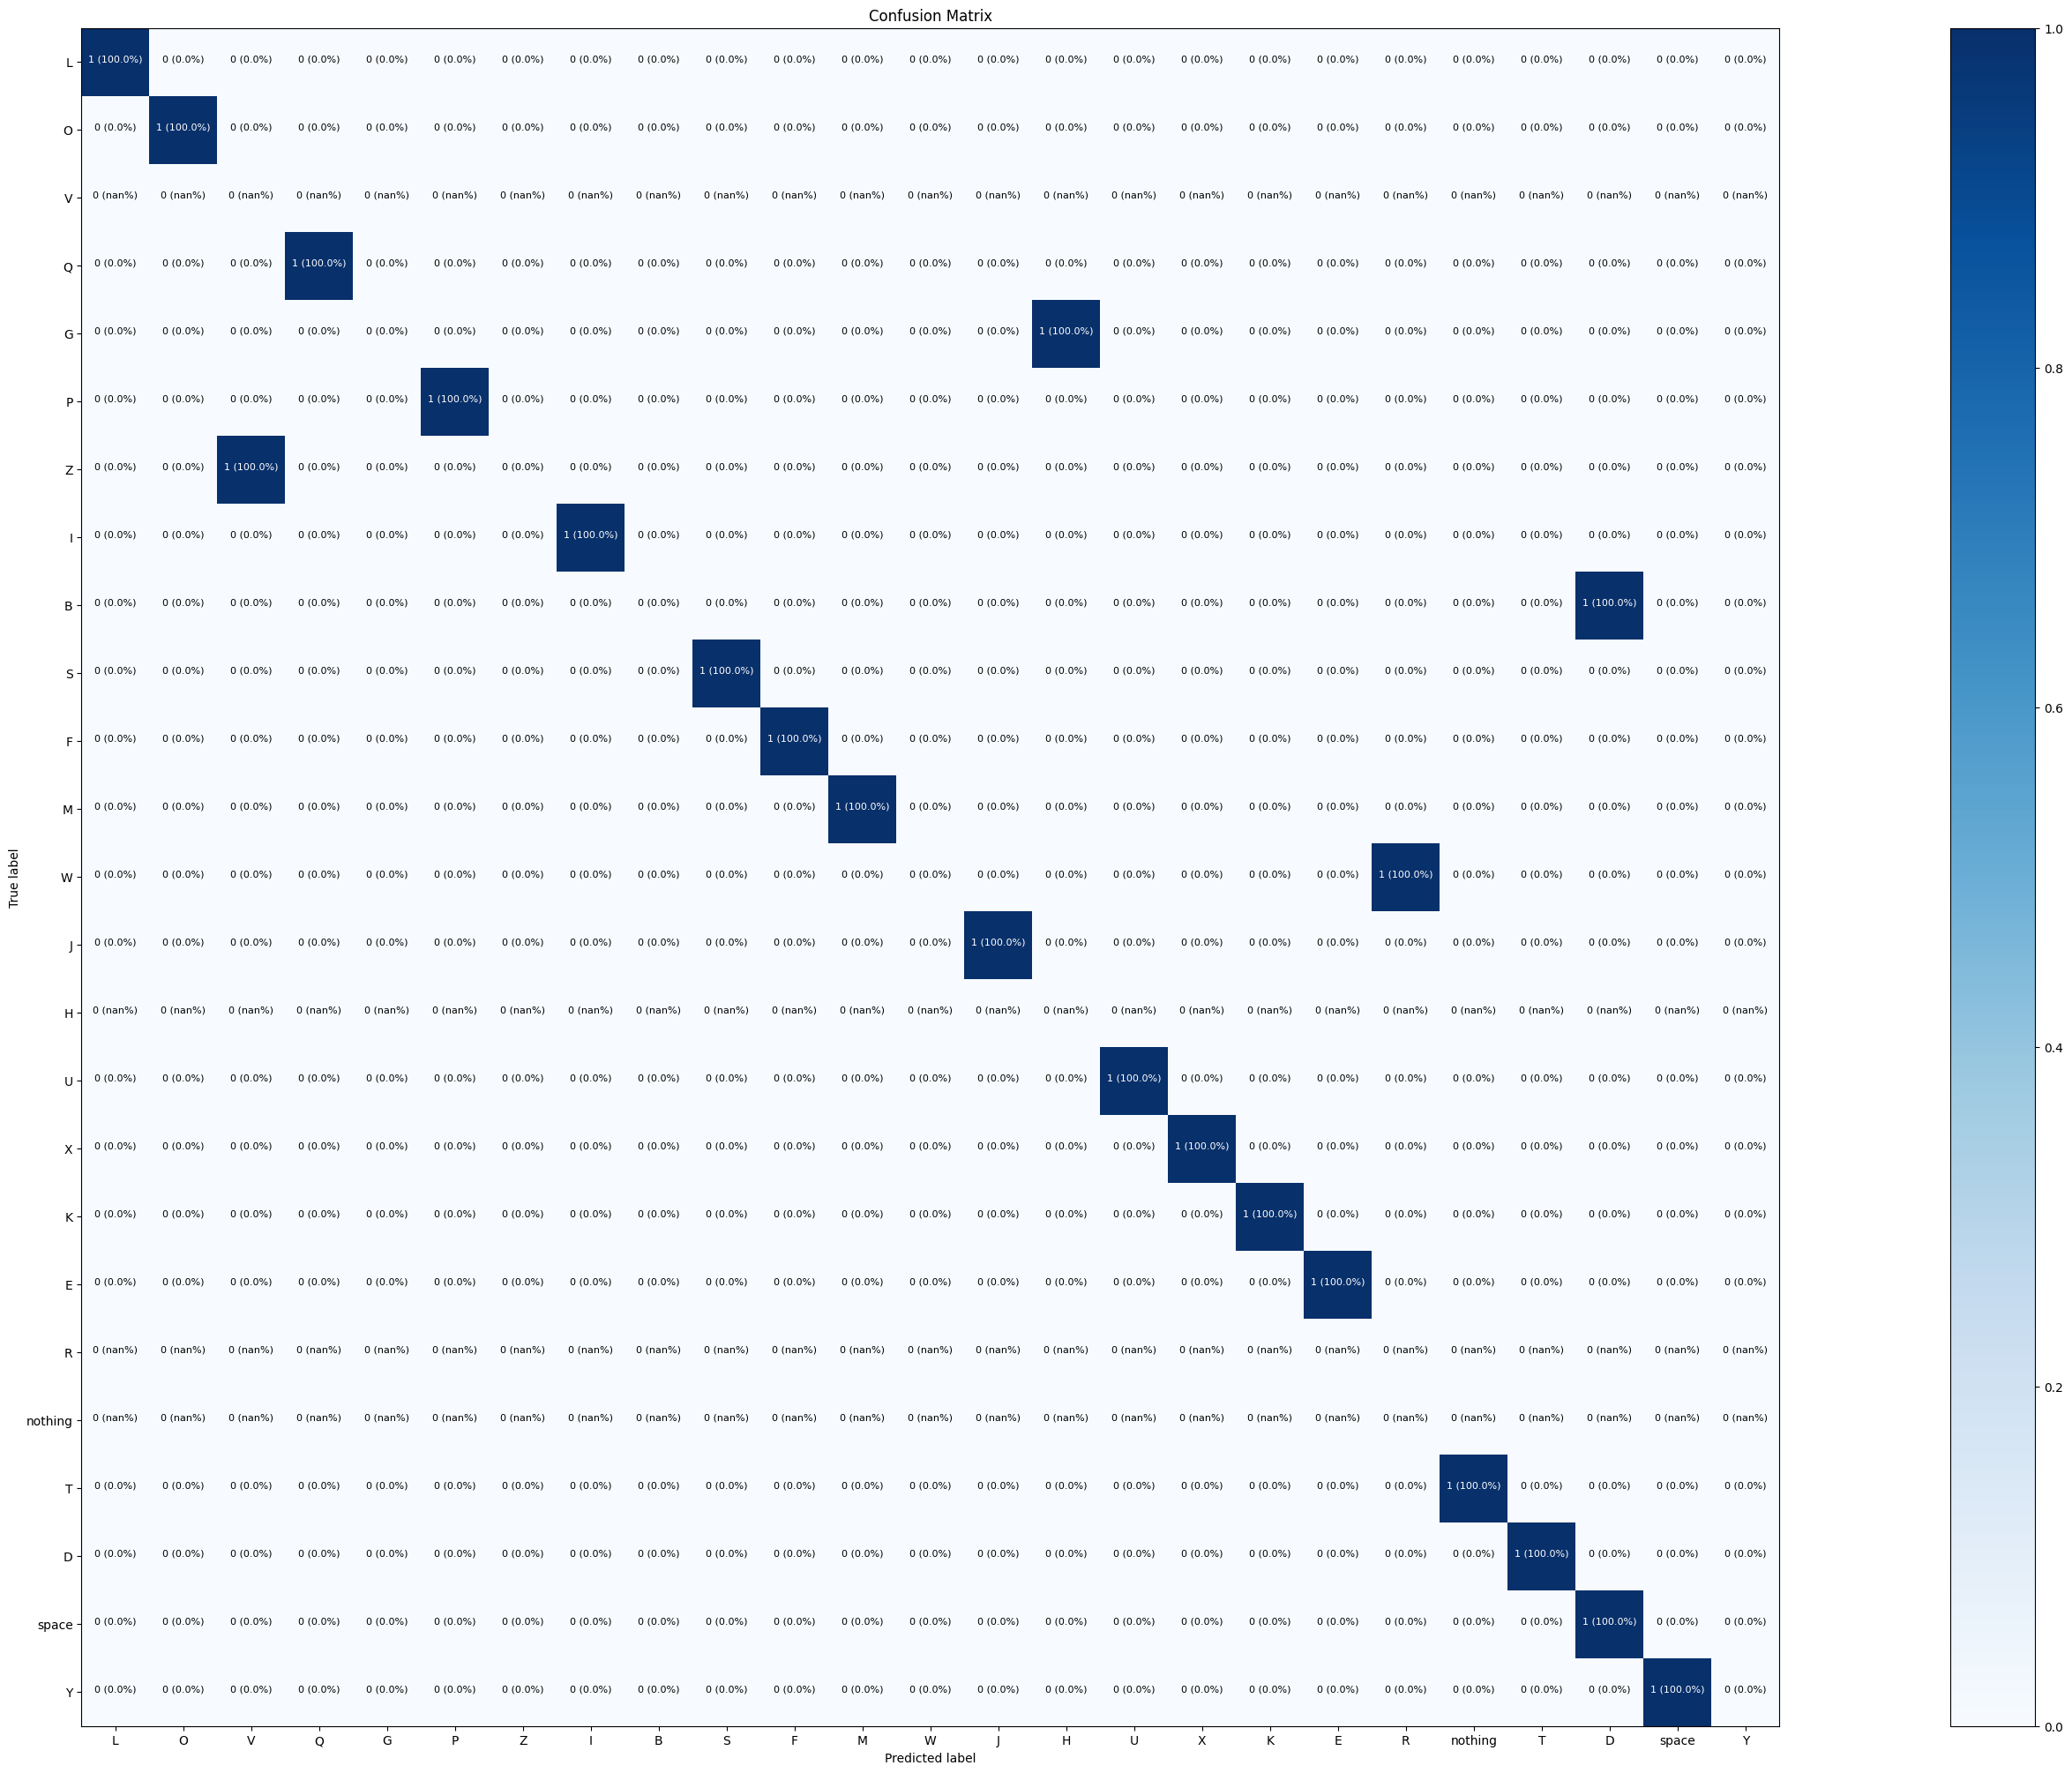

In [ ]:
words = ['L','O','V','Q','G','P','Z','I','B',
               'S','F','M','W','J','H','U','X',
               'K','E','R','nothing','T','D',
               'space','Y']
make_confusion_matrix(test_df['results'], y_predictTest, classes=words, figsize=(50, 25), text_size=8)

In [ ]:
len(words)

23

# Using Neural Networks

In [ ]:
from tqdm.notebook import tqdm
import random
import shutil

## Creating target class folders and moving images there

In [ ]:
trainData_dir

['/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/K',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/V',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/T',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/S',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/U',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/I',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/D',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/F',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/X',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/H',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/B',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Q',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/C',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A',
 '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/space',
 '/con

### Spltting data into training and testing sets

In [ ]:
def train_test(folder_paths: list[str], new_folder_path: str, sample_size=0.2):
    # Making test and train folders
    print(f"Making train and test folders in {new_folder_path}\n")
    test_fol = new_folder_path + '/' + 'test'
    os.makedirs(test_fol, exist_ok=True)

    train_fol = new_folder_path + '/' + 'train'
    os.makedirs(train_fol, exist_ok=True)

    for fol_path in tqdm(folder_paths):
        all_files = os.listdir(fol_path)
        test_size = int(len(all_files)*sample_size)
        print(f"\nThere are {len(all_files)} total images in '{fol_path}' so we're going to copy {test_size} images for testing.")
        print(f"Getting {test_size} random images for {fol_path}...")
        random_test = random.sample([j for j in range(len(all_files))], test_size)
        random_test.sort()

        # Making new directory
        label = fol_path.split('/')[-1]
        print(f'Making new folder for {label} in test and train folders')
        new_test = test_fol + '/' + label
        os.makedirs(new_test, exist_ok=True)

        new_train = train_fol + '/' + label
        os.makedirs(new_train, exist_ok=True)


        # Coping files to new folder/directory
        print(f"Coping testing files to {test_fol} and training files to {train_fol}")
        print('\n')
        j, k = 0, 0
        while j < len(all_files):
            original_path = fol_path + '/' + all_files[j]
            if k < len(random_test) and j == random_test[k]:
                tar_path = new_test + '/' + all_files[j]
                shutil.copy2(original_path, tar_path)
                k += 1
            else:
                tar_path = new_train + '/' + all_files[j]
                shutil.copy2(original_path, tar_path)
            j += 1

        assert len(os.listdir(new_test)) + len(os.listdir(new_train)) == len(all_files)
        assert len(os.listdir(new_test)) == test_size

In [ ]:
folder_paths = trainData_dir
new_folder_path = '/content/target_dataset'
sample_size=0.2
train_test(folder_paths, new_folder_path, sample_size)

Making train and test folders in /content/target_dataset



  0%|          | 0/29 [00:00<?, ?it/s]


There are 3000 total images in '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/K' so we're going to copy 600 images for testing.
Getting 600 random images for /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/K...
Making new folder for K in test and train folders
Coping testing files to /content/target_dataset/test and training files to /content/target_dataset/train



There are 3000 total images in '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/V' so we're going to copy 600 images for testing.
Getting 600 random images for /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/V...
Making new folder for V in test and train folders
Coping testing files to /content/target_dataset/test and training files to /content/target_dataset/train



There are 3000 total images in '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/T' so we're going to copy 600 images for testing.
Getting 600 random images for /content/asl-alphabet/asl_alphabet_tr

## Getting Familier with Data

* We have total 87000 images from which 69600 will be used for training the model and remaining 17400 will be used for testing the model

Alphabet in image is H



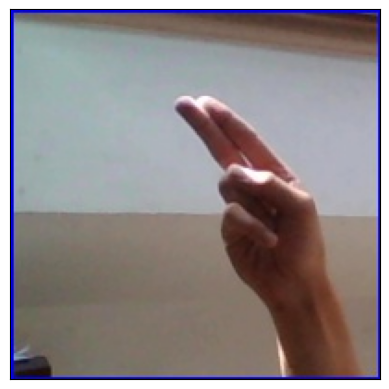



(200, 200, 3)


In [ ]:
# Printing random images from train dataset
train_set = '/content/target_dataset/train'
label = random.choice(os.listdir(train_set))
label_path = os.path.join(train_set, label)
img_path = os.path.join(label_path, random.choice(os.listdir(label_path)))
print(f'Alphabet in image is {label}', end='\n\n')
img = plt.imread(img_path)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()
print('\n')
print(img.shape)

Alphabet in image is N



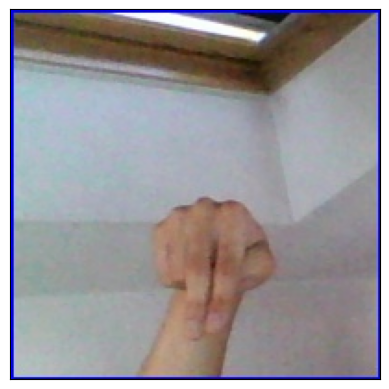



(200, 200, 3)


In [ ]:
# Printing random images from train dataset
test_set = '/content/target_dataset/test'
label = random.choice(os.listdir(test_set))
label_path = os.path.join(test_set, label)
img_path = os.path.join(label_path, random.choice(os.listdir(label_path)))
print(f'Alphabet in image is {label}', end='\n\n')
img = plt.imread(img_path)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()
print('\n')
print(img.shape)

## Training CNN Model

In [ ]:
def plot_loss_curves(history):
    """
    Return separate loss curves for training and validation metrics
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

### Preparing Data

In [ ]:
# Set the seed
tf.random.set_seed(42)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "/content/target_dataset/train"
test_dir = "/content/target_dataset/test"

# Importing data from directory and turning them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(200, 200),
                                              class_mode="categorical",
                                              seed=random_seed)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                              batch_size=32,
                                              target_size=(200,200),
                                              class_mode="categorical",
                                              seed=random_seed)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


### Model 1

In [ ]:
# Creating a CNN Model
model_1 = tf.keras.models.Sequential([
    layers.Conv2D(filters=10,
                  kernel_size=3,
                  activation="relu",
                  input_shape=(200, 200, 3)),
    layers.Conv2D(10, 3, activation="relu"),
    layers.MaxPool2D(pool_size=2,
                     padding="valid"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(29, activation="softmax")
])


In [ ]:
# Complie the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 10)        910       
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 10)       0         
 2D)                                                    

runtime 11 min

In [ ]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
2175/2175 [==============================] - 133s 56ms/step - loss: 0.8170 - accuracy: 0.7511 - val_loss: 0.2381 - val_accuracy: 0.9298
Epoch 2/5
2175/2175 [==============================] - 114s 52ms/step - loss: 0.1274 - accuracy: 0.9592 - val_loss: 0.1388 - val_accuracy: 0.9574
Epoch 3/5
2175/2175 [==============================] - 116s 53ms/step - loss: 0.0681 - accuracy: 0.9783 - val_loss: 0.1301 - val_accuracy: 0.9646
Epoch 4/5
2175/2175 [==============================] - 115s 53ms/step - loss: 0.0512 - accuracy: 0.9835 - val_loss: 0.1006 - val_accuracy: 0.9691
Epoch 5/5
2175/2175 [==============================] - 143s 66ms/step - loss: 0.0394 - accuracy: 0.9879 - val_loss: 0.1555 - val_accuracy: 0.9571


<Axes: >

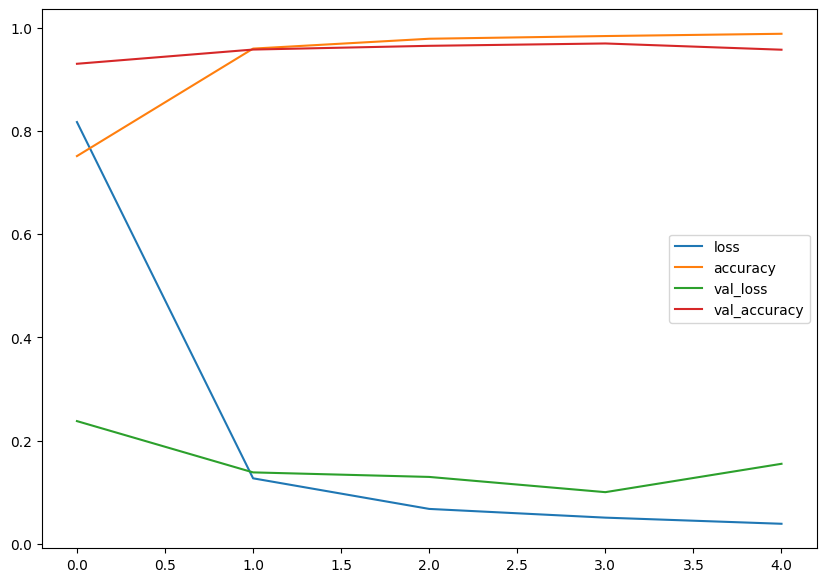

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(10,7))

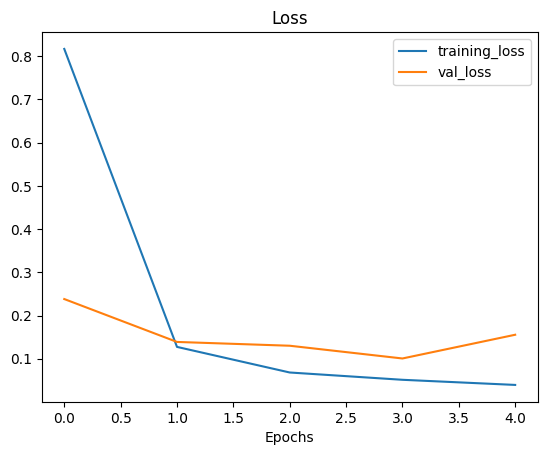

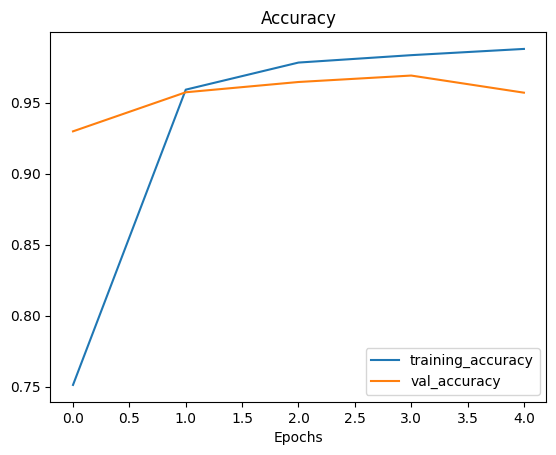

In [ ]:
plot_loss_curves(history_1)

### Model 2

In [ ]:
# Our input feature map is 200x200x3: 200x200 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(200, 200, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(29, activation='softmax')(x)


In [ ]:
# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model_2 = Model(img_input, output)
model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 46, 64)        1849

In [ ]:
history_2 = model_2.fit_generator(
      train_data,
      steps_per_epoch=len(train_data),  # 69600 images = batch_size * steps
      epochs=15,
      validation_data=valid_data,
      validation_steps=len(valid_data),  # 17400 images = batch_size * steps
      verbose=2)

Epoch 1/15
2175/2175 - 112s - loss: 0.5788 - acc: 0.8232 - val_loss: 0.1310 - val_acc: 0.9580 - 112s/epoch - 51ms/step
Epoch 2/15
2175/2175 - 109s - loss: 0.0688 - acc: 0.9787 - val_loss: 0.0845 - val_acc: 0.9737 - 109s/epoch - 50ms/step
Epoch 3/15
2175/2175 - 109s - loss: 0.0377 - acc: 0.9884 - val_loss: 0.0432 - val_acc: 0.9866 - 109s/epoch - 50ms/step
Epoch 4/15
2175/2175 - 108s - loss: 0.0320 - acc: 0.9905 - val_loss: 0.0238 - val_acc: 0.9920 - 108s/epoch - 50ms/step
Epoch 5/15
2175/2175 - 113s - loss: 0.0253 - acc: 0.9931 - val_loss: 0.0401 - val_acc: 0.9878 - 113s/epoch - 52ms/step
Epoch 6/15
2175/2175 - 107s - loss: 0.0176 - acc: 0.9949 - val_loss: 0.0141 - val_acc: 0.9959 - 107s/epoch - 49ms/step
Epoch 7/15
2175/2175 - 105s - loss: 0.0203 - acc: 0.9943 - val_loss: 0.0546 - val_acc: 0.9851 - 105s/epoch - 48ms/step
Epoch 8/15
2175/2175 - 107s - loss: 0.0129 - acc: 0.9963 - val_loss: 0.0738 - val_acc: 0.9836 - 107s/epoch - 49ms/step
Epoch 9/15
2175/2175 - 109s - loss: 0.0159 - acc

<Axes: >

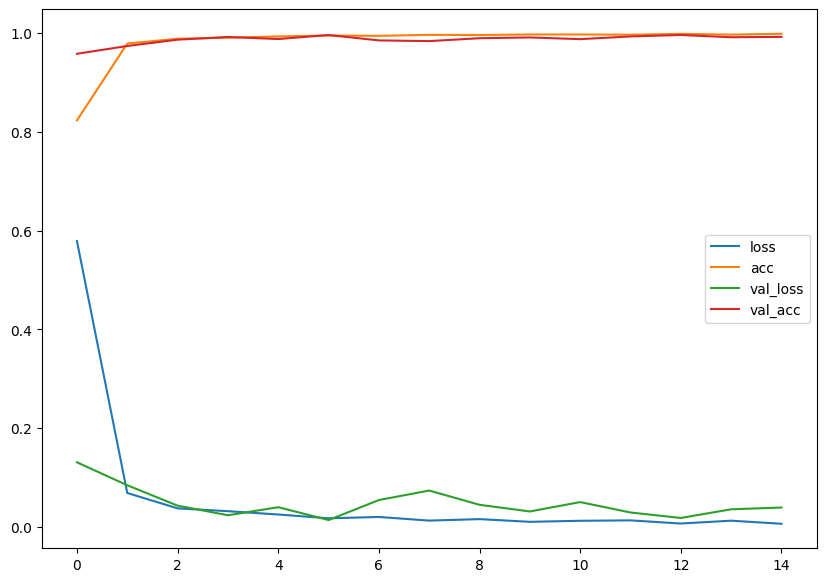

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(10,7))

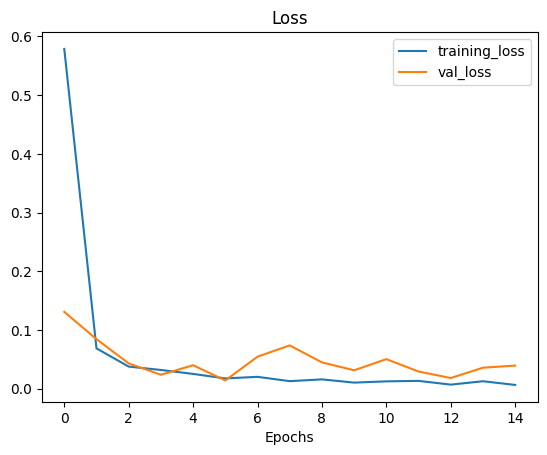

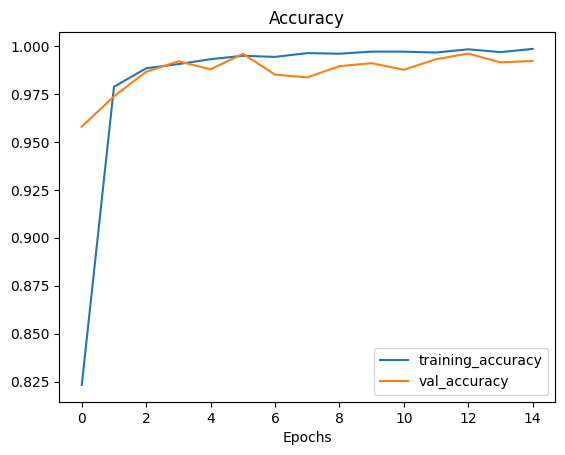

In [ ]:
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]

accuracy = history_2.history["acc"]
val_accuracy = history_2.history["val_acc"]

epochs = range(len(history_2.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

## Saving Model

In [ ]:
labels = ['K', 'V', 'T', 'S', 'U', 'I', 'D', 'F', 'X', 'H', 'B', 'Q', 'C', 'A', 'space', 'Z', 'W', 'M', 'E', 'O', 'Y', 'G', 'R', 'J', 'N', 'del', 'P', 'L', 'nothing']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model1_file_name = '/content/drive/MyDrive/models/tf_asl_alphabet_model_1.h5'
model_1.save(model1_file_name)

model2_file_name = '/content/drive/MyDrive/models/tf_asl_alphabet_model_2.h5'
model_2.save(model2_file_name)

In [ ]:
lite_model1_file = '/content/drive/MyDrive/models/tfLite_asl_alphabet_model_1.tflite'
tf_lite_coverter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tfLite_model_1 = tf_lite_coverter.convert()
open(lite_model1_file, 'wb').write(tfLite_model_1)

2578636

In [ ]:
lite_model2_file = '/content/drive/MyDrive/models/tfLite_asl_alphabet_model_2.tflite'
tf_lite_coverter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tfLite_model_2 = tf_lite_coverter.convert()
open(lite_model2_file, 'wb').write(tfLite_model_2)

69496956

In [ ]:
def convert_file_size_bytes(file_path, unit=None):
    size = os.path.getsize(file_path)
    if unit == 'KB':
        return f"File size: {round(size/1024, 3)} Kilobytes"
    elif unit == 'MB':
        return f"File size: {round(size/(1024*1024), 3)} Megabytes"
    else:
        return f"File size: {size} bytes"

In [ ]:
tf_model_1 = convert_file_size_bytes('/content/drive/MyDrive/models/tf_asl_alphabet_model_1.h5', unit='MB')
print(f"File Name: tf_asl_alphabet_model_1.h5 {tf_model_1}")

tf_model_2 = convert_file_size_bytes('/content/drive/MyDrive/models/tf_asl_alphabet_model_2.h5', unit='MB')
print(f"\nFile Name: tf_asl_alphabet_model_2.h5 {tf_model_2}")

tfLite_model_1 = convert_file_size_bytes('/content/drive/MyDrive/models/tfLite_asl_alphabet_model_1.tflite', unit='MB')
print(f"\nFile Name: tfLite_asl_alphabet_model_1.tflite {tfLite_model_1}")

tfLite_model_2 = convert_file_size_bytes('/content/drive/MyDrive/models/tfLite_asl_alphabet_model_2.tflite', unit='MB')
print(f"\nFile Name: tfLite_asl_alphabet_model_2.tflite {tfLite_model_2}")

File Name: tf_asl_alphabet_model_1.h5 File size: 7.416 Megabytes

File Name: tf_asl_alphabet_model_2.h5 File size: 198.872 Megabytes

File Name: tfLite_asl_alphabet_model_1.tflite File size: 2.459 Megabytes

File Name: tfLite_asl_alphabet_model_2.tflite File size: 66.277 Megabytes


So **CNN Models** has perform best on this dataset with accuracy of 99% but they are time consuming.
We can also augment the data and train the model to decreas the over fitting issue.

# Maybe some useful functions

In [ ]:
for i in list(os.walk('/content/target_dataset'))[0]:
    print(i)

/content/target_dataset
['nothing', 'T', 'M', 'I', 'H', 'O', 'P', 'N', 'U', 'D', 'R', 'Y', 'S', 'L', 'X', 'B', 'space', 'F', 'E', 'Z', 'J', 'Q', 'A', 'V', 'C', 'G', 'W', 'K', 'del']
[]


In [ ]:
import collections

def deleting_files_in_folder_colab(folder_path: str):
    root, dirs, files = list(os.walk(folder_path))[0]
    # For each file in the directory
    for fil in files:
        # Construct the full path to the file
        file_path = os.path.join(root, fil)
        # Delete the file
        os.remove(file_path)
    # For each subdirectory in the directory
    all_dirs = collections.deque([os.path.join(root, dir) for dir in dirs])
    while len(all_dirs) != 0:
        temp = all_dirs.popleft()
        root1, dir1, fil1 = list(os.walk(temp))[0]

        # Construct the full path to the subdirectory
        for fil in fil1:
            file_path = os.path.join(root1, fil)
            os.remove(file_path)

        for dir in dir1:
            temp_path1 = os.path.join(root1, dir)
            if len(os.listdir(temp_path1)) == 0:
                os.rmdir(temp_path1)
            else:
                all_dirs.appendleft(temp_path1)
        # Delete the subdirectory
        if len(os.listdir(temp)) == 0:
            os.rmdir(temp)
        else:
            all_dirs.append(temp)

fol_dir = '/content/target_dataset'
deleting_files_in_folder_colab(fol_dir)